In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(313949, 828)
(313949, 1)
validation
(37720, 828)
(37720, 1)
test
(42261, 828)
(42261, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/32 [..............................] - ETA: 46s - loss: 0.2784 - STD: 1.0731e-04 - MAE: 0.5181

 4/32 [==>...........................] - ETA: 0s - loss: 0.1016 - STD: 5.2551e-04 - MAE: 0.2546 

 5/32 [===>..........................] - ETA: 1s - loss: 0.0842 - STD: 4.6718e-04 - MAE: 0.2210

 6/32 [====>.........................] - ETA: 1s - loss: 0.0736 - STD: 4.1047e-04 - MAE: 0.2019

 7/32 [=====>........................] - ETA: 1s - loss: 0.0664 - STD: 3.6247e-04 - MAE: 0.1899

 8/32 [======>.......................] - ETA: 1s - loss: 0.0614 - STD: 3.2290e-04 - MAE: 0.1823

 9/32 [=======>......................] - ETA: 1s - loss: 0.0576 - STD: 2.9019e-04 - MAE: 0.1770

10/32 [========>.....................] - ETA: 1s - loss: 0.0548 - STD: 2.6299e-04 - MAE: 0.1732

11/32 [=========>....................] - ETA: 1s - loss: 0.0526 - STD: 2.4009e-04 - MAE: 0.1704

12/32 [==========>...................] - ETA: 1s - loss: 0.0507 - STD: 2.2065e-04 - MAE: 0.1679

13/32 [===========>..................] - ETA: 1s - loss: 0.0491 - STD: 2.0403e-04 - MAE: 0.1660

14/32 [============>.................] - ETA: 0s - loss: 0.0478 - STD: 1.8979e-04 - MAE: 0.1642

15/32 [=============>................] - ETA: 0s - loss: 0.0466 - STD: 1.7753e-04 - MAE: 0.1626

16/32 [==============>...............] - ETA: 0s - loss: 0.0455 - STD: 1.6688e-04 - MAE: 0.1612

17/32 [==============>...............] - ETA: 0s - loss: 0.0445 - STD: 1.5757e-04 - MAE: 0.1597

18/32 [===============>..............] - ETA: 0s - loss: 0.0435 - STD: 1.4936e-04 - MAE: 0.1581

19/32 [================>.............] - ETA: 0s - loss: 0.0427 - STD: 1.4208e-04 - MAE: 0.1566

20/32 [=================>............] - ETA: 1s - loss: 0.0423 - STD: 1.3557e-04 - MAE: 0.1549

23/32 [====================>.........] - ETA: 0s - loss: 0.0396 - STD: 1.1985e-04 - MAE: 0.1494

25/32 [======================>.......] - ETA: 0s - loss: 0.0378 - STD: 1.1177e-04 - MAE: 0.1453

26/32 [=======================>......] - ETA: 0s - loss: 0.0369 - STD: 1.0825e-04 - MAE: 0.1431

27/32 [========================>.....] - ETA: 0s - loss: 0.0360 - STD: 1.0502e-04 - MAE: 0.1409

28/32 [=========================>....] - ETA: 0s - loss: 0.0351 - STD: 1.0202e-04 - MAE: 0.1386

29/32 [==========================>...] - ETA: 0s - loss: 0.0343 - STD: 9.9215e-05 - MAE: 0.1366

30/32 [===========================>..] - ETA: 0s - loss: 0.0335 - STD: 9.6582e-05 - MAE: 0.1346

31/32 [============================>.] - ETA: 0s - loss: 0.0327 - STD: 9.4105e-05 - MAE: 0.1328

32/32 [==============================] - ETA: 0s - loss: 0.0320 - STD: 9.1758e-05 - MAE: 0.1312

32/32 [==============================] - 4s 97ms/step - loss: 0.0320 - STD: 9.1758e-05 - MAE: 0.1312 - val_loss: 0.0101 - val_STD: 1.0319e-05 - val_MAE: 0.0840


Epoch 2/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0110 - STD: 1.8672e-05 - MAE: 0.0862

 2/32 [>.............................] - ETA: 1s - loss: 0.0113 - STD: 1.8193e-05 - MAE: 0.0882

 3/32 [=>............................] - ETA: 1s - loss: 0.0116 - STD: 1.7829e-05 - MAE: 0.0900

 4/32 [==>...........................] - ETA: 1s - loss: 0.0118 - STD: 1.7379e-05 - MAE: 0.0914

 5/32 [===>..........................] - ETA: 1s - loss: 0.0120 - STD: 1.6821e-05 - MAE: 0.0925

 6/32 [====>.........................] - ETA: 1s - loss: 0.0121 - STD: 1.6203e-05 - MAE: 0.0931

 7/32 [=====>........................] - ETA: 1s - loss: 0.0122 - STD: 1.5541e-05 - MAE: 0.0932

 8/32 [======>.......................] - ETA: 1s - loss: 0.0121 - STD: 1.4876e-05 - MAE: 0.0928

 9/32 [=======>......................] - ETA: 1s - loss: 0.0120 - STD: 1.4211e-05 - MAE: 0.0922

10/32 [========>.....................] - ETA: 1s - loss: 0.0118 - STD: 1.3570e-05 - MAE: 0.0914

11/32 [=========>....................] - ETA: 1s - loss: 0.0117 - STD: 1.2961e-05 - MAE: 0.0905

12/32 [==========>...................] - ETA: 1s - loss: 0.0116 - STD: 1.2388e-05 - MAE: 0.0896

14/32 [============>.................] - ETA: 0s - loss: 0.0114 - STD: 1.1367e-05 - MAE: 0.0881

15/32 [=============>................] - ETA: 0s - loss: 0.0114 - STD: 1.0920e-05 - MAE: 0.0875

16/32 [==============>...............] - ETA: 0s - loss: 0.0114 - STD: 1.0517e-05 - MAE: 0.0868

17/32 [==============>...............] - ETA: 0s - loss: 0.0113 - STD: 1.0148e-05 - MAE: 0.0863

18/32 [===============>..............] - ETA: 0s - loss: 0.0113 - STD: 9.8135e-06 - MAE: 0.0858

19/32 [================>.............] - ETA: 0s - loss: 0.0113 - STD: 9.5094e-06 - MAE: 0.0853

20/32 [=================>............] - ETA: 0s - loss: 0.0112 - STD: 9.2368e-06 - MAE: 0.0849

21/32 [==================>...........] - ETA: 0s - loss: 0.0112 - STD: 8.9881e-06 - MAE: 0.0845

22/32 [===================>..........] - ETA: 0s - loss: 0.0112 - STD: 8.7630e-06 - MAE: 0.0842

23/32 [====================>.........] - ETA: 0s - loss: 0.0112 - STD: 8.5600e-06 - MAE: 0.0839

24/32 [=====================>........] - ETA: 0s - loss: 0.0111 - STD: 8.3764e-06 - MAE: 0.0836

25/32 [======================>.......] - ETA: 0s - loss: 0.0111 - STD: 8.2126e-06 - MAE: 0.0834

26/32 [=======================>......] - ETA: 0s - loss: 0.0111 - STD: 8.0631e-06 - MAE: 0.0832

27/32 [========================>.....] - ETA: 0s - loss: 0.0110 - STD: 7.9272e-06 - MAE: 0.0830

28/32 [=========================>....] - ETA: 0s - loss: 0.0110 - STD: 7.8004e-06 - MAE: 0.0829

29/32 [==========================>...] - ETA: 0s - loss: 0.0110 - STD: 7.6870e-06 - MAE: 0.0828

30/32 [===========================>..] - ETA: 0s - loss: 0.0110 - STD: 7.5798e-06 - MAE: 0.0827

31/32 [============================>.] - ETA: 0s - loss: 0.0109 - STD: 7.4797e-06 - MAE: 0.0826

32/32 [==============================] - ETA: 0s - loss: 0.0109 - STD: 7.3877e-06 - MAE: 0.0826

32/32 [==============================] - 2s 61ms/step - loss: 0.0109 - STD: 7.3877e-06 - MAE: 0.0826 - val_loss: 0.0095 - val_STD: 2.3109e-06 - val_MAE: 0.0791


Epoch 3/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0103 - STD: 4.5482e-06 - MAE: 0.0815

 2/32 [>.............................] - ETA: 1s - loss: 0.0104 - STD: 4.5649e-06 - MAE: 0.0815

 3/32 [=>............................] - ETA: 1s - loss: 0.0105 - STD: 4.5660e-06 - MAE: 0.0819

 4/32 [==>...........................] - ETA: 1s - loss: 0.0104 - STD: 4.5578e-06 - MAE: 0.0817

 5/32 [===>..........................] - ETA: 1s - loss: 0.0104 - STD: 4.5455e-06 - MAE: 0.0816

 6/32 [====>.........................] - ETA: 1s - loss: 0.0103 - STD: 4.5354e-06 - MAE: 0.0812

 7/32 [=====>........................] - ETA: 1s - loss: 0.0103 - STD: 4.5153e-06 - MAE: 0.0811

 8/32 [======>.......................] - ETA: 1s - loss: 0.0103 - STD: 4.4987e-06 - MAE: 0.0809

 9/32 [=======>......................] - ETA: 1s - loss: 0.0103 - STD: 4.4877e-06 - MAE: 0.0806

10/32 [========>.....................] - ETA: 1s - loss: 0.0103 - STD: 4.4715e-06 - MAE: 0.0805

11/32 [=========>....................] - ETA: 1s - loss: 0.0103 - STD: 4.4582e-06 - MAE: 0.0803

12/32 [==========>...................] - ETA: 1s - loss: 0.0103 - STD: 4.4476e-06 - MAE: 0.0802

13/32 [===========>..................] - ETA: 1s - loss: 0.0103 - STD: 4.4405e-06 - MAE: 0.0801

14/32 [============>.................] - ETA: 1s - loss: 0.0103 - STD: 4.4338e-06 - MAE: 0.0798

15/32 [=============>................] - ETA: 0s - loss: 0.0103 - STD: 4.4306e-06 - MAE: 0.0798

17/32 [==============>...............] - ETA: 0s - loss: 0.0103 - STD: 4.4385e-06 - MAE: 0.0797

18/32 [===============>..............] - ETA: 0s - loss: 0.0103 - STD: 4.4421e-06 - MAE: 0.0797

19/32 [================>.............] - ETA: 0s - loss: 0.0103 - STD: 4.4478e-06 - MAE: 0.0796

20/32 [=================>............] - ETA: 0s - loss: 0.0103 - STD: 4.4560e-06 - MAE: 0.0796

21/32 [==================>...........] - ETA: 0s - loss: 0.0103 - STD: 4.4654e-06 - MAE: 0.0796

22/32 [===================>..........] - ETA: 0s - loss: 0.0103 - STD: 4.4806e-06 - MAE: 0.0796

23/32 [====================>.........] - ETA: 0s - loss: 0.0103 - STD: 4.4934e-06 - MAE: 0.0796

24/32 [=====================>........] - ETA: 0s - loss: 0.0103 - STD: 4.5075e-06 - MAE: 0.0796

25/32 [======================>.......] - ETA: 0s - loss: 0.0103 - STD: 4.5230e-06 - MAE: 0.0797

26/32 [=======================>......] - ETA: 0s - loss: 0.0103 - STD: 4.5394e-06 - MAE: 0.0796

27/32 [========================>.....] - ETA: 0s - loss: 0.0103 - STD: 4.5553e-06 - MAE: 0.0796

28/32 [=========================>....] - ETA: 0s - loss: 0.0103 - STD: 4.5732e-06 - MAE: 0.0796

29/32 [==========================>...] - ETA: 0s - loss: 0.0103 - STD: 4.5899e-06 - MAE: 0.0797

30/32 [===========================>..] - ETA: 0s - loss: 0.0103 - STD: 4.6079e-06 - MAE: 0.0797

31/32 [============================>.] - ETA: 0s - loss: 0.0103 - STD: 4.6255e-06 - MAE: 0.0797

32/32 [==============================] - ETA: 0s - loss: 0.0103 - STD: 4.6427e-06 - MAE: 0.0797

32/32 [==============================] - 2s 61ms/step - loss: 0.0103 - STD: 4.6427e-06 - MAE: 0.0797 - val_loss: 0.0093 - val_STD: 3.7499e-06 - val_MAE: 0.0766


Epoch 4/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0103 - STD: 5.2531e-06 - MAE: 0.0796

 2/32 [>.............................] - ETA: 1s - loss: 0.0103 - STD: 5.2809e-06 - MAE: 0.0794

 3/32 [=>............................] - ETA: 1s - loss: 0.0103 - STD: 5.2780e-06 - MAE: 0.0795

 4/32 [==>...........................] - ETA: 1s - loss: 0.0103 - STD: 5.2988e-06 - MAE: 0.0794

 5/32 [===>..........................] - ETA: 1s - loss: 0.0102 - STD: 5.3100e-06 - MAE: 0.0791

 6/32 [====>.........................] - ETA: 1s - loss: 0.0102 - STD: 5.3278e-06 - MAE: 0.0790

 7/32 [=====>........................] - ETA: 1s - loss: 0.0102 - STD: 5.3527e-06 - MAE: 0.0790

 8/32 [======>.......................] - ETA: 1s - loss: 0.0102 - STD: 5.3780e-06 - MAE: 0.0791

 9/32 [=======>......................] - ETA: 1s - loss: 0.0102 - STD: 5.3977e-06 - MAE: 0.0791

10/32 [========>.....................] - ETA: 1s - loss: 0.0102 - STD: 5.4206e-06 - MAE: 0.0791

11/32 [=========>....................] - ETA: 1s - loss: 0.0102 - STD: 5.4458e-06 - MAE: 0.0790

12/32 [==========>...................] - ETA: 1s - loss: 0.0102 - STD: 5.4744e-06 - MAE: 0.0791

13/32 [===========>..................] - ETA: 1s - loss: 0.0103 - STD: 5.5040e-06 - MAE: 0.0791

14/32 [============>.................] - ETA: 1s - loss: 0.0102 - STD: 5.5340e-06 - MAE: 0.0790

15/32 [=============>................] - ETA: 0s - loss: 0.0102 - STD: 5.5666e-06 - MAE: 0.0791

16/32 [==============>...............] - ETA: 0s - loss: 0.0102 - STD: 5.5960e-06 - MAE: 0.0791

17/32 [==============>...............] - ETA: 0s - loss: 0.0103 - STD: 5.6303e-06 - MAE: 0.0791

18/32 [===============>..............] - ETA: 0s - loss: 0.0103 - STD: 5.6669e-06 - MAE: 0.0792

19/32 [================>.............] - ETA: 0s - loss: 0.0103 - STD: 5.7003e-06 - MAE: 0.0792

20/32 [=================>............] - ETA: 0s - loss: 0.0103 - STD: 5.7373e-06 - MAE: 0.0793

21/32 [==================>...........] - ETA: 0s - loss: 0.0103 - STD: 5.7760e-06 - MAE: 0.0793

22/32 [===================>..........] - ETA: 0s - loss: 0.0103 - STD: 5.8088e-06 - MAE: 0.0793

23/32 [====================>.........] - ETA: 0s - loss: 0.0103 - STD: 5.8455e-06 - MAE: 0.0793

24/32 [=====================>........] - ETA: 0s - loss: 0.0103 - STD: 5.8836e-06 - MAE: 0.0793

25/32 [======================>.......] - ETA: 0s - loss: 0.0103 - STD: 5.9208e-06 - MAE: 0.0794

26/32 [=======================>......] - ETA: 0s - loss: 0.0103 - STD: 5.9573e-06 - MAE: 0.0794

28/32 [=========================>....] - ETA: 0s - loss: 0.0103 - STD: 6.0368e-06 - MAE: 0.0793

29/32 [==========================>...] - ETA: 0s - loss: 0.0103 - STD: 6.0772e-06 - MAE: 0.0793

30/32 [===========================>..] - ETA: 0s - loss: 0.0103 - STD: 6.1160e-06 - MAE: 0.0793

31/32 [============================>.] - ETA: 0s - loss: 0.0103 - STD: 6.1546e-06 - MAE: 0.0793

32/32 [==============================] - ETA: 0s - loss: 0.0103 - STD: 6.1922e-06 - MAE: 0.0793

32/32 [==============================] - 2s 60ms/step - loss: 0.0103 - STD: 6.1922e-06 - MAE: 0.0793 - val_loss: 0.0093 - val_STD: 6.1705e-06 - val_MAE: 0.0759


Epoch 5/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0102 - STD: 7.4432e-06 - MAE: 0.0785

 2/32 [>.............................] - ETA: 1s - loss: 0.0103 - STD: 7.4765e-06 - MAE: 0.0788

 3/32 [=>............................] - ETA: 1s - loss: 0.0103 - STD: 7.5199e-06 - MAE: 0.0788

 4/32 [==>...........................] - ETA: 1s - loss: 0.0103 - STD: 7.5808e-06 - MAE: 0.0789

 5/32 [===>..........................] - ETA: 1s - loss: 0.0103 - STD: 7.6309e-06 - MAE: 0.0790

 6/32 [====>.........................] - ETA: 1s - loss: 0.0104 - STD: 7.6910e-06 - MAE: 0.0791

 7/32 [=====>........................] - ETA: 1s - loss: 0.0103 - STD: 7.7498e-06 - MAE: 0.0792

 8/32 [======>.......................] - ETA: 1s - loss: 0.0103 - STD: 7.7972e-06 - MAE: 0.0791

 9/32 [=======>......................] - ETA: 1s - loss: 0.0103 - STD: 7.8515e-06 - MAE: 0.0791

10/32 [========>.....................] - ETA: 1s - loss: 0.0103 - STD: 7.9036e-06 - MAE: 0.0792

11/32 [=========>....................] - ETA: 1s - loss: 0.0103 - STD: 7.9743e-06 - MAE: 0.0792

13/32 [===========>..................] - ETA: 1s - loss: 0.0103 - STD: 8.1054e-06 - MAE: 0.0793

14/32 [============>.................] - ETA: 1s - loss: 0.0103 - STD: 8.1719e-06 - MAE: 0.0793

15/32 [=============>................] - ETA: 0s - loss: 0.0103 - STD: 8.2348e-06 - MAE: 0.0793

16/32 [==============>...............] - ETA: 0s - loss: 0.0103 - STD: 8.2939e-06 - MAE: 0.0794

17/32 [==============>...............] - ETA: 0s - loss: 0.0103 - STD: 8.3466e-06 - MAE: 0.0795

18/32 [===============>..............] - ETA: 0s - loss: 0.0103 - STD: 8.4007e-06 - MAE: 0.0794

19/32 [================>.............] - ETA: 0s - loss: 0.0103 - STD: 8.4596e-06 - MAE: 0.0794

20/32 [=================>............] - ETA: 0s - loss: 0.0103 - STD: 8.5180e-06 - MAE: 0.0794

21/32 [==================>...........] - ETA: 0s - loss: 0.0103 - STD: 8.5805e-06 - MAE: 0.0794

22/32 [===================>..........] - ETA: 0s - loss: 0.0103 - STD: 8.6391e-06 - MAE: 0.0794

23/32 [====================>.........] - ETA: 0s - loss: 0.0103 - STD: 8.7005e-06 - MAE: 0.0794

24/32 [=====================>........] - ETA: 0s - loss: 0.0103 - STD: 8.7635e-06 - MAE: 0.0794

25/32 [======================>.......] - ETA: 0s - loss: 0.0103 - STD: 8.8267e-06 - MAE: 0.0793

26/32 [=======================>......] - ETA: 0s - loss: 0.0103 - STD: 8.8907e-06 - MAE: 0.0794

27/32 [========================>.....] - ETA: 0s - loss: 0.0103 - STD: 8.9539e-06 - MAE: 0.0793

28/32 [=========================>....] - ETA: 0s - loss: 0.0103 - STD: 9.0205e-06 - MAE: 0.0793

29/32 [==========================>...] - ETA: 0s - loss: 0.0103 - STD: 9.0835e-06 - MAE: 0.0793

30/32 [===========================>..] - ETA: 0s - loss: 0.0103 - STD: 9.1433e-06 - MAE: 0.0793

31/32 [============================>.] - ETA: 0s - loss: 0.0103 - STD: 9.2079e-06 - MAE: 0.0793

32/32 [==============================] - ETA: 0s - loss: 0.0103 - STD: 9.2769e-06 - MAE: 0.0793

32/32 [==============================] - 2s 61ms/step - loss: 0.0103 - STD: 9.2769e-06 - MAE: 0.0793 - val_loss: 0.0093 - val_STD: 1.0063e-05 - val_MAE: 0.0762


Epoch 6/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0107 - STD: 1.1450e-05 - MAE: 0.0803

 2/32 [>.............................] - ETA: 1s - loss: 0.0106 - STD: 1.1552e-05 - MAE: 0.0800

 3/32 [=>............................] - ETA: 1s - loss: 0.0105 - STD: 1.1669e-05 - MAE: 0.0798

 4/32 [==>...........................] - ETA: 1s - loss: 0.0104 - STD: 1.1771e-05 - MAE: 0.0798

 5/32 [===>..........................] - ETA: 1s - loss: 0.0104 - STD: 1.1881e-05 - MAE: 0.0799

 6/32 [====>.........................] - ETA: 1s - loss: 0.0104 - STD: 1.1974e-05 - MAE: 0.0798

 7/32 [=====>........................] - ETA: 1s - loss: 0.0104 - STD: 1.2076e-05 - MAE: 0.0798

 8/32 [======>.......................] - ETA: 1s - loss: 0.0103 - STD: 1.2159e-05 - MAE: 0.0796

 9/32 [=======>......................] - ETA: 1s - loss: 0.0103 - STD: 1.2249e-05 - MAE: 0.0796

10/32 [========>.....................] - ETA: 1s - loss: 0.0103 - STD: 1.2342e-05 - MAE: 0.0797

11/32 [=========>....................] - ETA: 1s - loss: 0.0103 - STD: 1.2446e-05 - MAE: 0.0796

13/32 [===========>..................] - ETA: 1s - loss: 0.0103 - STD: 1.2612e-05 - MAE: 0.0797

14/32 [============>.................] - ETA: 0s - loss: 0.0103 - STD: 1.2703e-05 - MAE: 0.0796

15/32 [=============>................] - ETA: 0s - loss: 0.0103 - STD: 1.2802e-05 - MAE: 0.0796

16/32 [==============>...............] - ETA: 0s - loss: 0.0103 - STD: 1.2902e-05 - MAE: 0.0796

17/32 [==============>...............] - ETA: 0s - loss: 0.0103 - STD: 1.3004e-05 - MAE: 0.0795

18/32 [===============>..............] - ETA: 0s - loss: 0.0103 - STD: 1.3098e-05 - MAE: 0.0795

19/32 [================>.............] - ETA: 0s - loss: 0.0103 - STD: 1.3200e-05 - MAE: 0.0795

20/32 [=================>............] - ETA: 0s - loss: 0.0103 - STD: 1.3304e-05 - MAE: 0.0795

21/32 [==================>...........] - ETA: 0s - loss: 0.0103 - STD: 1.3408e-05 - MAE: 0.0795

22/32 [===================>..........] - ETA: 0s - loss: 0.0103 - STD: 1.3510e-05 - MAE: 0.0795

23/32 [====================>.........] - ETA: 0s - loss: 0.0103 - STD: 1.3621e-05 - MAE: 0.0795

24/32 [=====================>........] - ETA: 0s - loss: 0.0103 - STD: 1.3728e-05 - MAE: 0.0795

25/32 [======================>.......] - ETA: 0s - loss: 0.0103 - STD: 1.3836e-05 - MAE: 0.0794

26/32 [=======================>......] - ETA: 0s - loss: 0.0103 - STD: 1.3952e-05 - MAE: 0.0794

27/32 [========================>.....] - ETA: 0s - loss: 0.0103 - STD: 1.4070e-05 - MAE: 0.0794

28/32 [=========================>....] - ETA: 0s - loss: 0.0103 - STD: 1.4192e-05 - MAE: 0.0794

29/32 [==========================>...] - ETA: 0s - loss: 0.0103 - STD: 1.4310e-05 - MAE: 0.0794

30/32 [===========================>..] - ETA: 0s - loss: 0.0103 - STD: 1.4419e-05 - MAE: 0.0794

31/32 [============================>.] - ETA: 0s - loss: 0.0103 - STD: 1.4534e-05 - MAE: 0.0794

32/32 [==============================] - ETA: 0s - loss: 0.0103 - STD: 1.4651e-05 - MAE: 0.0793

32/32 [==============================] - 2s 62ms/step - loss: 0.0103 - STD: 1.4651e-05 - MAE: 0.0793 - val_loss: 0.0093 - val_STD: 1.6589e-05 - val_MAE: 0.0763


Epoch 7/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0102 - STD: 1.8776e-05 - MAE: 0.0788

 2/32 [>.............................] - ETA: 1s - loss: 0.0101 - STD: 1.8843e-05 - MAE: 0.0787

 3/32 [=>............................] - ETA: 1s - loss: 0.0102 - STD: 1.9011e-05 - MAE: 0.0792

 4/32 [==>...........................] - ETA: 1s - loss: 0.0102 - STD: 1.9158e-05 - MAE: 0.0793

 5/32 [===>..........................] - ETA: 1s - loss: 0.0103 - STD: 1.9300e-05 - MAE: 0.0795

 6/32 [====>.........................] - ETA: 1s - loss: 0.0103 - STD: 1.9447e-05 - MAE: 0.0794

 7/32 [=====>........................] - ETA: 1s - loss: 0.0103 - STD: 1.9598e-05 - MAE: 0.0794

 8/32 [======>.......................] - ETA: 1s - loss: 0.0103 - STD: 1.9728e-05 - MAE: 0.0795

 9/32 [=======>......................] - ETA: 1s - loss: 0.0104 - STD: 1.9909e-05 - MAE: 0.0795

10/32 [========>.....................] - ETA: 1s - loss: 0.0104 - STD: 2.0103e-05 - MAE: 0.0795

11/32 [=========>....................] - ETA: 1s - loss: 0.0103 - STD: 2.0270e-05 - MAE: 0.0795

12/32 [==========>...................] - ETA: 1s - loss: 0.0103 - STD: 2.0419e-05 - MAE: 0.0794

14/32 [============>.................] - ETA: 0s - loss: 0.0103 - STD: 2.0793e-05 - MAE: 0.0794

15/32 [=============>................] - ETA: 0s - loss: 0.0103 - STD: 2.0969e-05 - MAE: 0.0794

16/32 [==============>...............] - ETA: 0s - loss: 0.0103 - STD: 2.1164e-05 - MAE: 0.0794

17/32 [==============>...............] - ETA: 0s - loss: 0.0103 - STD: 2.1336e-05 - MAE: 0.0794

18/32 [===============>..............] - ETA: 0s - loss: 0.0103 - STD: 2.1523e-05 - MAE: 0.0794

19/32 [================>.............] - ETA: 0s - loss: 0.0103 - STD: 2.1713e-05 - MAE: 0.0794

20/32 [=================>............] - ETA: 0s - loss: 0.0103 - STD: 2.1903e-05 - MAE: 0.0794

21/32 [==================>...........] - ETA: 0s - loss: 0.0103 - STD: 2.2093e-05 - MAE: 0.0794

22/32 [===================>..........] - ETA: 0s - loss: 0.0103 - STD: 2.2297e-05 - MAE: 0.0794

23/32 [====================>.........] - ETA: 0s - loss: 0.0103 - STD: 2.2493e-05 - MAE: 0.0793

24/32 [=====================>........] - ETA: 0s - loss: 0.0103 - STD: 2.2687e-05 - MAE: 0.0793

25/32 [======================>.......] - ETA: 0s - loss: 0.0103 - STD: 2.2888e-05 - MAE: 0.0793

26/32 [=======================>......] - ETA: 0s - loss: 0.0103 - STD: 2.3086e-05 - MAE: 0.0793

27/32 [========================>.....] - ETA: 0s - loss: 0.0103 - STD: 2.3286e-05 - MAE: 0.0793

28/32 [=========================>....] - ETA: 0s - loss: 0.0103 - STD: 2.3493e-05 - MAE: 0.0793

29/32 [==========================>...] - ETA: 0s - loss: 0.0103 - STD: 2.3699e-05 - MAE: 0.0793

30/32 [===========================>..] - ETA: 0s - loss: 0.0103 - STD: 2.3919e-05 - MAE: 0.0793

31/32 [============================>.] - ETA: 0s - loss: 0.0103 - STD: 2.4142e-05 - MAE: 0.0793

32/32 [==============================] - ETA: 0s - loss: 0.0103 - STD: 2.4364e-05 - MAE: 0.0793

32/32 [==============================] - 2s 60ms/step - loss: 0.0103 - STD: 2.4364e-05 - MAE: 0.0793 - val_loss: 0.0093 - val_STD: 2.8431e-05 - val_MAE: 0.0765


Epoch 8/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0108 - STD: 3.1636e-05 - MAE: 0.0808

 2/32 [>.............................] - ETA: 1s - loss: 0.0106 - STD: 3.2075e-05 - MAE: 0.0803

 3/32 [=>............................] - ETA: 1s - loss: 0.0105 - STD: 3.2406e-05 - MAE: 0.0802

 4/32 [==>...........................] - ETA: 1s - loss: 0.0105 - STD: 3.2749e-05 - MAE: 0.0802

 5/32 [===>..........................] - ETA: 1s - loss: 0.0105 - STD: 3.2999e-05 - MAE: 0.0801

 7/32 [=====>........................] - ETA: 1s - loss: 0.0104 - STD: 3.3636e-05 - MAE: 0.0799

 8/32 [======>.......................] - ETA: 1s - loss: 0.0104 - STD: 3.3863e-05 - MAE: 0.0797

 9/32 [=======>......................] - ETA: 1s - loss: 0.0103 - STD: 3.4140e-05 - MAE: 0.0796

10/32 [========>.....................] - ETA: 1s - loss: 0.0103 - STD: 3.4412e-05 - MAE: 0.0794

11/32 [=========>....................] - ETA: 1s - loss: 0.0103 - STD: 3.4673e-05 - MAE: 0.0794

12/32 [==========>...................] - ETA: 1s - loss: 0.0103 - STD: 3.4935e-05 - MAE: 0.0793

13/32 [===========>..................] - ETA: 1s - loss: 0.0103 - STD: 3.5197e-05 - MAE: 0.0793

14/32 [============>.................] - ETA: 0s - loss: 0.0102 - STD: 3.5492e-05 - MAE: 0.0792

15/32 [=============>................] - ETA: 0s - loss: 0.0102 - STD: 3.5763e-05 - MAE: 0.0792

16/32 [==============>...............] - ETA: 0s - loss: 0.0103 - STD: 3.6081e-05 - MAE: 0.0792

17/32 [==============>...............] - ETA: 0s - loss: 0.0103 - STD: 3.6398e-05 - MAE: 0.0793

18/32 [===============>..............] - ETA: 0s - loss: 0.0103 - STD: 3.6702e-05 - MAE: 0.0793

19/32 [================>.............] - ETA: 0s - loss: 0.0103 - STD: 3.7030e-05 - MAE: 0.0793

20/32 [=================>............] - ETA: 0s - loss: 0.0103 - STD: 3.7369e-05 - MAE: 0.0793

21/32 [==================>...........] - ETA: 0s - loss: 0.0103 - STD: 3.7736e-05 - MAE: 0.0794

22/32 [===================>..........] - ETA: 0s - loss: 0.0103 - STD: 3.8071e-05 - MAE: 0.0793

23/32 [====================>.........] - ETA: 0s - loss: 0.0103 - STD: 3.8423e-05 - MAE: 0.0794

24/32 [=====================>........] - ETA: 0s - loss: 0.0103 - STD: 3.8764e-05 - MAE: 0.0794

25/32 [======================>.......] - ETA: 0s - loss: 0.0103 - STD: 3.9142e-05 - MAE: 0.0794

26/32 [=======================>......] - ETA: 0s - loss: 0.0103 - STD: 3.9512e-05 - MAE: 0.0794

27/32 [========================>.....] - ETA: 0s - loss: 0.0103 - STD: 3.9902e-05 - MAE: 0.0794

28/32 [=========================>....] - ETA: 0s - loss: 0.0103 - STD: 4.0300e-05 - MAE: 0.0794

29/32 [==========================>...] - ETA: 0s - loss: 0.0103 - STD: 4.0690e-05 - MAE: 0.0794

30/32 [===========================>..] - ETA: 0s - loss: 0.0103 - STD: 4.1073e-05 - MAE: 0.0794

31/32 [============================>.] - ETA: 0s - loss: 0.0103 - STD: 4.1471e-05 - MAE: 0.0793

32/32 [==============================] - ETA: 0s - loss: 0.0103 - STD: 4.1877e-05 - MAE: 0.0793

32/32 [==============================] - 2s 58ms/step - loss: 0.0103 - STD: 4.1877e-05 - MAE: 0.0793 - val_loss: 0.0093 - val_STD: 4.9115e-05 - val_MAE: 0.0761


Epoch 9/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0103 - STD: 5.4897e-05 - MAE: 0.0793

 2/32 [>.............................] - ETA: 1s - loss: 0.0101 - STD: 5.5576e-05 - MAE: 0.0787

 3/32 [=>............................] - ETA: 1s - loss: 0.0103 - STD: 5.6250e-05 - MAE: 0.0792

 4/32 [==>...........................] - ETA: 1s - loss: 0.0103 - STD: 5.6745e-05 - MAE: 0.0793

 5/32 [===>..........................] - ETA: 1s - loss: 0.0103 - STD: 5.7264e-05 - MAE: 0.0792

 6/32 [====>.........................] - ETA: 1s - loss: 0.0103 - STD: 5.7794e-05 - MAE: 0.0793

 7/32 [=====>........................] - ETA: 1s - loss: 0.0103 - STD: 5.8370e-05 - MAE: 0.0792

 8/32 [======>.......................] - ETA: 1s - loss: 0.0103 - STD: 5.8911e-05 - MAE: 0.0792

 9/32 [=======>......................] - ETA: 1s - loss: 0.0103 - STD: 5.9602e-05 - MAE: 0.0793

10/32 [========>.....................] - ETA: 1s - loss: 0.0103 - STD: 6.0229e-05 - MAE: 0.0793

11/32 [=========>....................] - ETA: 1s - loss: 0.0103 - STD: 6.0786e-05 - MAE: 0.0793

12/32 [==========>...................] - ETA: 1s - loss: 0.0103 - STD: 6.1470e-05 - MAE: 0.0792

13/32 [===========>..................] - ETA: 1s - loss: 0.0103 - STD: 6.2121e-05 - MAE: 0.0792

14/32 [============>.................] - ETA: 1s - loss: 0.0103 - STD: 6.2785e-05 - MAE: 0.0792

15/32 [=============>................] - ETA: 0s - loss: 0.0103 - STD: 6.3490e-05 - MAE: 0.0792

16/32 [==============>...............] - ETA: 0s - loss: 0.0103 - STD: 6.4215e-05 - MAE: 0.0793

17/32 [==============>...............] - ETA: 0s - loss: 0.0103 - STD: 6.4872e-05 - MAE: 0.0793

18/32 [===============>..............] - ETA: 0s - loss: 0.0103 - STD: 6.5567e-05 - MAE: 0.0793

19/32 [================>.............] - ETA: 0s - loss: 0.0103 - STD: 6.6233e-05 - MAE: 0.0793

20/32 [=================>............] - ETA: 0s - loss: 0.0102 - STD: 6.6935e-05 - MAE: 0.0792

21/32 [==================>...........] - ETA: 0s - loss: 0.0102 - STD: 6.7621e-05 - MAE: 0.0792

22/32 [===================>..........] - ETA: 0s - loss: 0.0102 - STD: 6.8305e-05 - MAE: 0.0792

23/32 [====================>.........] - ETA: 0s - loss: 0.0103 - STD: 6.9046e-05 - MAE: 0.0792

24/32 [=====================>........] - ETA: 0s - loss: 0.0103 - STD: 6.9797e-05 - MAE: 0.0792

25/32 [======================>.......] - ETA: 0s - loss: 0.0103 - STD: 7.0577e-05 - MAE: 0.0792

26/32 [=======================>......] - ETA: 0s - loss: 0.0103 - STD: 7.1402e-05 - MAE: 0.0792

27/32 [========================>.....] - ETA: 0s - loss: 0.0103 - STD: 7.2204e-05 - MAE: 0.0792

28/32 [=========================>....] - ETA: 0s - loss: 0.0103 - STD: 7.3015e-05 - MAE: 0.0792

30/32 [===========================>..] - ETA: 0s - loss: 0.0103 - STD: 7.4763e-05 - MAE: 0.0792

31/32 [============================>.] - ETA: 0s - loss: 0.0103 - STD: 7.5655e-05 - MAE: 0.0793

32/32 [==============================] - ETA: 0s - loss: 0.0103 - STD: 7.6568e-05 - MAE: 0.0793

32/32 [==============================] - 2s 60ms/step - loss: 0.0103 - STD: 7.6568e-05 - MAE: 0.0793 - val_loss: 0.0093 - val_STD: 9.5363e-05 - val_MAE: 0.0766


Epoch 10/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0102 - STD: 1.0715e-04 - MAE: 0.0790

 2/32 [>.............................] - ETA: 1s - loss: 0.0102 - STD: 1.0848e-04 - MAE: 0.0790

 3/32 [=>............................] - ETA: 1s - loss: 0.0102 - STD: 1.0964e-04 - MAE: 0.0791

 4/32 [==>...........................] - ETA: 1s - loss: 0.0103 - STD: 1.1094e-04 - MAE: 0.0793

 5/32 [===>..........................] - ETA: 1s - loss: 0.0103 - STD: 1.1222e-04 - MAE: 0.0794

 6/32 [====>.........................] - ETA: 1s - loss: 0.0102 - STD: 1.1367e-04 - MAE: 0.0793

 7/32 [=====>........................] - ETA: 1s - loss: 0.0103 - STD: 1.1490e-04 - MAE: 0.0793

 8/32 [======>.......................] - ETA: 1s - loss: 0.0103 - STD: 1.1604e-04 - MAE: 0.0793

 9/32 [=======>......................] - ETA: 1s - loss: 0.0103 - STD: 1.1747e-04 - MAE: 0.0793

10/32 [========>.....................] - ETA: 1s - loss: 0.0103 - STD: 1.1903e-04 - MAE: 0.0793

11/32 [=========>....................] - ETA: 1s - loss: 0.0103 - STD: 1.2043e-04 - MAE: 0.0792

12/32 [==========>...................] - ETA: 1s - loss: 0.0103 - STD: 1.2202e-04 - MAE: 0.0793

13/32 [===========>..................] - ETA: 1s - loss: 0.0103 - STD: 1.2367e-04 - MAE: 0.0793

14/32 [============>.................] - ETA: 1s - loss: 0.0103 - STD: 1.2542e-04 - MAE: 0.0793

15/32 [=============>................] - ETA: 0s - loss: 0.0103 - STD: 1.2711e-04 - MAE: 0.0793

16/32 [==============>...............] - ETA: 0s - loss: 0.0103 - STD: 1.2889e-04 - MAE: 0.0793

17/32 [==============>...............] - ETA: 0s - loss: 0.0103 - STD: 1.3056e-04 - MAE: 0.0793

18/32 [===============>..............] - ETA: 0s - loss: 0.0103 - STD: 1.3244e-04 - MAE: 0.0793

19/32 [================>.............] - ETA: 0s - loss: 0.0103 - STD: 1.3432e-04 - MAE: 0.0793

20/32 [=================>............] - ETA: 0s - loss: 0.0103 - STD: 1.3624e-04 - MAE: 0.0793

21/32 [==================>...........] - ETA: 0s - loss: 0.0103 - STD: 1.3812e-04 - MAE: 0.0793

22/32 [===================>..........] - ETA: 0s - loss: 0.0103 - STD: 1.4009e-04 - MAE: 0.0793

23/32 [====================>.........] - ETA: 0s - loss: 0.0103 - STD: 1.4211e-04 - MAE: 0.0793

24/32 [=====================>........] - ETA: 0s - loss: 0.0103 - STD: 1.4419e-04 - MAE: 0.0793

25/32 [======================>.......] - ETA: 0s - loss: 0.0103 - STD: 1.4633e-04 - MAE: 0.0793

26/32 [=======================>......] - ETA: 0s - loss: 0.0103 - STD: 1.4847e-04 - MAE: 0.0793

27/32 [========================>.....] - ETA: 0s - loss: 0.0103 - STD: 1.5063e-04 - MAE: 0.0793

28/32 [=========================>....] - ETA: 0s - loss: 0.0103 - STD: 1.5284e-04 - MAE: 0.0792

30/32 [===========================>..] - ETA: 0s - loss: 0.0102 - STD: 1.5761e-04 - MAE: 0.0792

31/32 [============================>.] - ETA: 0s - loss: 0.0102 - STD: 1.6012e-04 - MAE: 0.0792

32/32 [==============================] - ETA: 0s - loss: 0.0103 - STD: 1.6269e-04 - MAE: 0.0793

32/32 [==============================] - 2s 59ms/step - loss: 0.0103 - STD: 1.6269e-04 - MAE: 0.0793 - val_loss: 0.0092 - val_STD: 2.1945e-04 - val_MAE: 0.0763


Epoch 11/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0103 - STD: 2.4896e-04 - MAE: 0.0798

 2/32 [>.............................] - ETA: 1s - loss: 0.0102 - STD: 2.5259e-04 - MAE: 0.0792

 3/32 [=>............................] - ETA: 1s - loss: 0.0102 - STD: 2.5570e-04 - MAE: 0.0793

 4/32 [==>...........................] - ETA: 1s - loss: 0.0103 - STD: 2.5964e-04 - MAE: 0.0795

 5/32 [===>..........................] - ETA: 1s - loss: 0.0103 - STD: 2.6316e-04 - MAE: 0.0793

 6/32 [====>.........................] - ETA: 1s - loss: 0.0103 - STD: 2.6776e-04 - MAE: 0.0796

 7/32 [=====>........................] - ETA: 1s - loss: 0.0103 - STD: 2.7217e-04 - MAE: 0.0795

 8/32 [======>.......................] - ETA: 1s - loss: 0.0103 - STD: 2.7668e-04 - MAE: 0.0794

 9/32 [=======>......................] - ETA: 1s - loss: 0.0103 - STD: 2.8086e-04 - MAE: 0.0793

10/32 [========>.....................] - ETA: 1s - loss: 0.0102 - STD: 2.8536e-04 - MAE: 0.0793

11/32 [=========>....................] - ETA: 1s - loss: 0.0103 - STD: 2.8999e-04 - MAE: 0.0794

12/32 [==========>...................] - ETA: 1s - loss: 0.0103 - STD: 2.9479e-04 - MAE: 0.0794

13/32 [===========>..................] - ETA: 1s - loss: 0.0103 - STD: 2.9962e-04 - MAE: 0.0793

14/32 [============>.................] - ETA: 1s - loss: 0.0103 - STD: 3.0499e-04 - MAE: 0.0793

16/32 [==============>...............] - ETA: 0s - loss: 0.0102 - STD: 3.1527e-04 - MAE: 0.0793

17/32 [==============>...............] - ETA: 0s - loss: 0.0102 - STD: 3.2072e-04 - MAE: 0.0793

18/32 [===============>..............] - ETA: 0s - loss: 0.0103 - STD: 3.2639e-04 - MAE: 0.0794

19/32 [================>.............] - ETA: 0s - loss: 0.0103 - STD: 3.3230e-04 - MAE: 0.0794

20/32 [=================>............] - ETA: 0s - loss: 0.0103 - STD: 3.3817e-04 - MAE: 0.0794

21/32 [==================>...........] - ETA: 0s - loss: 0.0103 - STD: 3.4433e-04 - MAE: 0.0794

22/32 [===================>..........] - ETA: 0s - loss: 0.0103 - STD: 3.5081e-04 - MAE: 0.0794

23/32 [====================>.........] - ETA: 0s - loss: 0.0103 - STD: 3.5742e-04 - MAE: 0.0794

24/32 [=====================>........] - ETA: 0s - loss: 0.0103 - STD: 3.6415e-04 - MAE: 0.0794

25/32 [======================>.......] - ETA: 0s - loss: 0.0103 - STD: 3.7098e-04 - MAE: 0.0793

26/32 [=======================>......] - ETA: 0s - loss: 0.0103 - STD: 3.7804e-04 - MAE: 0.0794

27/32 [========================>.....] - ETA: 0s - loss: 0.0103 - STD: 3.8529e-04 - MAE: 0.0794

28/32 [=========================>....] - ETA: 0s - loss: 0.0103 - STD: 3.9251e-04 - MAE: 0.0794

29/32 [==========================>...] - ETA: 0s - loss: 0.0103 - STD: 3.9999e-04 - MAE: 0.0794

30/32 [===========================>..] - ETA: 0s - loss: 0.0103 - STD: 4.0788e-04 - MAE: 0.0793

31/32 [============================>.] - ETA: 0s - loss: 0.0102 - STD: 4.1570e-04 - MAE: 0.0793

32/32 [==============================] - ETA: 0s - loss: 0.0102 - STD: 4.2421e-04 - MAE: 0.0792

32/32 [==============================] - 2s 60ms/step - loss: 0.0102 - STD: 4.2421e-04 - MAE: 0.0792 - val_loss: 0.0092 - val_STD: 6.2780e-04 - val_MAE: 0.0762


Epoch 12/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0103 - STD: 7.0372e-04 - MAE: 0.0789

 2/32 [>.............................] - ETA: 1s - loss: 0.0102 - STD: 7.1640e-04 - MAE: 0.0790

 3/32 [=>............................] - ETA: 1s - loss: 0.0103 - STD: 7.3094e-04 - MAE: 0.0794

 5/32 [===>..........................] - ETA: 1s - loss: 0.0103 - STD: 7.5710e-04 - MAE: 0.0793

 6/32 [====>.........................] - ETA: 1s - loss: 0.0102 - STD: 7.7083e-04 - MAE: 0.0791

 7/32 [=====>........................] - ETA: 1s - loss: 0.0103 - STD: 7.8604e-04 - MAE: 0.0793

 8/32 [======>.......................] - ETA: 1s - loss: 0.0103 - STD: 7.9998e-04 - MAE: 0.0793

 9/32 [=======>......................] - ETA: 1s - loss: 0.0103 - STD: 8.1562e-04 - MAE: 0.0793

10/32 [========>.....................] - ETA: 1s - loss: 0.0102 - STD: 8.3177e-04 - MAE: 0.0792

11/32 [=========>....................] - ETA: 1s - loss: 0.0102 - STD: 8.4827e-04 - MAE: 0.0791

12/32 [==========>...................] - ETA: 1s - loss: 0.0102 - STD: 8.6431e-04 - MAE: 0.0791

13/32 [===========>..................] - ETA: 1s - loss: 0.0102 - STD: 8.8083e-04 - MAE: 0.0791

14/32 [============>.................] - ETA: 0s - loss: 0.0102 - STD: 8.9752e-04 - MAE: 0.0791

15/32 [=============>................] - ETA: 0s - loss: 0.0102 - STD: 9.1442e-04 - MAE: 0.0790

16/32 [==============>...............] - ETA: 0s - loss: 0.0102 - STD: 9.3201e-04 - MAE: 0.0790

17/32 [==============>...............] - ETA: 0s - loss: 0.0102 - STD: 9.5041e-04 - MAE: 0.0789

18/32 [===============>..............] - ETA: 0s - loss: 0.0102 - STD: 9.6926e-04 - MAE: 0.0790

19/32 [================>.............] - ETA: 0s - loss: 0.0102 - STD: 9.8891e-04 - MAE: 0.0790

20/32 [=================>............] - ETA: 0s - loss: 0.0102 - STD: 0.0010 - MAE: 0.0790    

21/32 [==================>...........] - ETA: 0s - loss: 0.0102 - STD: 0.0010 - MAE: 0.0790

22/32 [===================>..........] - ETA: 0s - loss: 0.0102 - STD: 0.0011 - MAE: 0.0790

23/32 [====================>.........] - ETA: 0s - loss: 0.0102 - STD: 0.0011 - MAE: 0.0790

24/32 [=====================>........] - ETA: 0s - loss: 0.0102 - STD: 0.0011 - MAE: 0.0790

25/32 [======================>.......] - ETA: 0s - loss: 0.0102 - STD: 0.0011 - MAE: 0.0790

26/32 [=======================>......] - ETA: 0s - loss: 0.0102 - STD: 0.0011 - MAE: 0.0790

27/32 [========================>.....] - ETA: 0s - loss: 0.0102 - STD: 0.0012 - MAE: 0.0790

28/32 [=========================>....] - ETA: 0s - loss: 0.0102 - STD: 0.0012 - MAE: 0.0790

29/32 [==========================>...] - ETA: 0s - loss: 0.0102 - STD: 0.0012 - MAE: 0.0790

30/32 [===========================>..] - ETA: 0s - loss: 0.0102 - STD: 0.0013 - MAE: 0.0790

31/32 [============================>.] - ETA: 0s - loss: 0.0102 - STD: 0.0013 - MAE: 0.0790

32/32 [==============================] - ETA: 0s - loss: 0.0102 - STD: 0.0013 - MAE: 0.0790

32/32 [==============================] - 2s 61ms/step - loss: 0.0102 - STD: 0.0013 - MAE: 0.0790 - val_loss: 0.0091 - val_STD: 0.0021 - val_MAE: 0.0758


Epoch 13/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0103 - STD: 0.0023 - MAE: 0.0796

 2/32 [>.............................] - ETA: 1s - loss: 0.0101 - STD: 0.0023 - MAE: 0.0790

 3/32 [=>............................] - ETA: 1s - loss: 0.0101 - STD: 0.0024 - MAE: 0.0790

 4/32 [==>...........................] - ETA: 1s - loss: 0.0101 - STD: 0.0024 - MAE: 0.0790

 5/32 [===>..........................] - ETA: 1s - loss: 0.0101 - STD: 0.0025 - MAE: 0.0790

 6/32 [====>.........................] - ETA: 1s - loss: 0.0101 - STD: 0.0025 - MAE: 0.0790

 7/32 [=====>........................] - ETA: 1s - loss: 0.0101 - STD: 0.0026 - MAE: 0.0791

 8/32 [======>.......................] - ETA: 1s - loss: 0.0101 - STD: 0.0026 - MAE: 0.0791

 9/32 [=======>......................] - ETA: 1s - loss: 0.0101 - STD: 0.0027 - MAE: 0.0790

10/32 [========>.....................] - ETA: 1s - loss: 0.0101 - STD: 0.0027 - MAE: 0.0790

11/32 [=========>....................] - ETA: 1s - loss: 0.0101 - STD: 0.0028 - MAE: 0.0789

12/32 [==========>...................] - ETA: 1s - loss: 0.0101 - STD: 0.0029 - MAE: 0.0788

13/32 [===========>..................] - ETA: 1s - loss: 0.0100 - STD: 0.0029 - MAE: 0.0787

14/32 [============>.................] - ETA: 1s - loss: 0.0100 - STD: 0.0030 - MAE: 0.0786

15/32 [=============>................] - ETA: 0s - loss: 0.0100 - STD: 0.0030 - MAE: 0.0787

16/32 [==============>...............] - ETA: 0s - loss: 0.0100 - STD: 0.0031 - MAE: 0.0787

17/32 [==============>...............] - ETA: 0s - loss: 0.0100 - STD: 0.0032 - MAE: 0.0786

18/32 [===============>..............] - ETA: 0s - loss: 0.0100 - STD: 0.0032 - MAE: 0.0786

20/32 [=================>............] - ETA: 0s - loss: 0.0100 - STD: 0.0034 - MAE: 0.0785

21/32 [==================>...........] - ETA: 0s - loss: 0.0100 - STD: 0.0035 - MAE: 0.0785

22/32 [===================>..........] - ETA: 0s - loss: 0.0100 - STD: 0.0035 - MAE: 0.0785

23/32 [====================>.........] - ETA: 0s - loss: 0.0100 - STD: 0.0036 - MAE: 0.0785

24/32 [=====================>........] - ETA: 0s - loss: 0.0100 - STD: 0.0037 - MAE: 0.0785

25/32 [======================>.......] - ETA: 0s - loss: 0.0100 - STD: 0.0038 - MAE: 0.0785

26/32 [=======================>......] - ETA: 0s - loss: 0.0100 - STD: 0.0039 - MAE: 0.0785

27/32 [========================>.....] - ETA: 0s - loss: 0.0100 - STD: 0.0040 - MAE: 0.0785

28/32 [=========================>....] - ETA: 0s - loss: 0.0100 - STD: 0.0041 - MAE: 0.0784

29/32 [==========================>...] - ETA: 0s - loss: 0.0100 - STD: 0.0041 - MAE: 0.0784

30/32 [===========================>..] - ETA: 0s - loss: 0.0100 - STD: 0.0042 - MAE: 0.0783

31/32 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 0.0043 - MAE: 0.0783

32/32 [==============================] - ETA: 0s - loss: 0.0099 - STD: 0.0044 - MAE: 0.0783

32/32 [==============================] - 2s 60ms/step - loss: 0.0099 - STD: 0.0044 - MAE: 0.0783 - val_loss: 0.0088 - val_STD: 0.0073 - val_MAE: 0.0743


Epoch 14/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0099 - STD: 0.0080 - MAE: 0.0776

 2/32 [>.............................] - ETA: 1s - loss: 0.0098 - STD: 0.0081 - MAE: 0.0774

 3/32 [=>............................] - ETA: 1s - loss: 0.0097 - STD: 0.0083 - MAE: 0.0772

 4/32 [==>...........................] - ETA: 1s - loss: 0.0097 - STD: 0.0084 - MAE: 0.0773

 5/32 [===>..........................] - ETA: 1s - loss: 0.0097 - STD: 0.0086 - MAE: 0.0772

 6/32 [====>.........................] - ETA: 1s - loss: 0.0097 - STD: 0.0088 - MAE: 0.0772

 7/32 [=====>........................] - ETA: 1s - loss: 0.0097 - STD: 0.0090 - MAE: 0.0773

 8/32 [======>.......................] - ETA: 1s - loss: 0.0097 - STD: 0.0091 - MAE: 0.0772

10/32 [========>.....................] - ETA: 1s - loss: 0.0096 - STD: 0.0095 - MAE: 0.0771

11/32 [=========>....................] - ETA: 1s - loss: 0.0096 - STD: 0.0097 - MAE: 0.0770

12/32 [==========>...................] - ETA: 1s - loss: 0.0096 - STD: 0.0099 - MAE: 0.0769

13/32 [===========>..................] - ETA: 1s - loss: 0.0096 - STD: 0.0102 - MAE: 0.0769

14/32 [============>.................] - ETA: 1s - loss: 0.0096 - STD: 0.0104 - MAE: 0.0769

15/32 [=============>................] - ETA: 0s - loss: 0.0095 - STD: 0.0106 - MAE: 0.0768

16/32 [==============>...............] - ETA: 0s - loss: 0.0095 - STD: 0.0108 - MAE: 0.0768

17/32 [==============>...............] - ETA: 0s - loss: 0.0095 - STD: 0.0110 - MAE: 0.0768

18/32 [===============>..............] - ETA: 0s - loss: 0.0095 - STD: 0.0112 - MAE: 0.0767

19/32 [================>.............] - ETA: 0s - loss: 0.0095 - STD: 0.0115 - MAE: 0.0766

20/32 [=================>............] - ETA: 0s - loss: 0.0095 - STD: 0.0117 - MAE: 0.0766

21/32 [==================>...........] - ETA: 0s - loss: 0.0095 - STD: 0.0119 - MAE: 0.0765

22/32 [===================>..........] - ETA: 0s - loss: 0.0094 - STD: 0.0122 - MAE: 0.0765

23/32 [====================>.........] - ETA: 0s - loss: 0.0094 - STD: 0.0124 - MAE: 0.0764

24/32 [=====================>........] - ETA: 0s - loss: 0.0094 - STD: 0.0126 - MAE: 0.0764

25/32 [======================>.......] - ETA: 0s - loss: 0.0094 - STD: 0.0129 - MAE: 0.0763

26/32 [=======================>......] - ETA: 0s - loss: 0.0094 - STD: 0.0131 - MAE: 0.0763

27/32 [========================>.....] - ETA: 0s - loss: 0.0094 - STD: 0.0134 - MAE: 0.0762

28/32 [=========================>....] - ETA: 0s - loss: 0.0094 - STD: 0.0137 - MAE: 0.0761

29/32 [==========================>...] - ETA: 0s - loss: 0.0094 - STD: 0.0139 - MAE: 0.0761

30/32 [===========================>..] - ETA: 0s - loss: 0.0093 - STD: 0.0142 - MAE: 0.0760

31/32 [============================>.] - ETA: 0s - loss: 0.0093 - STD: 0.0145 - MAE: 0.0760

32/32 [==============================] - ETA: 0s - loss: 0.0093 - STD: 0.0147 - MAE: 0.0760

32/32 [==============================] - 2s 63ms/step - loss: 0.0093 - STD: 0.0147 - MAE: 0.0760 - val_loss: 0.0082 - val_STD: 0.0221 - val_MAE: 0.0714


Epoch 15/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0086 - STD: 0.0236 - MAE: 0.0731

 2/32 [>.............................] - ETA: 1s - loss: 0.0086 - STD: 0.0239 - MAE: 0.0731

 3/32 [=>............................] - ETA: 1s - loss: 0.0088 - STD: 0.0242 - MAE: 0.0736

 4/32 [==>...........................] - ETA: 1s - loss: 0.0087 - STD: 0.0244 - MAE: 0.0734

 5/32 [===>..........................] - ETA: 1s - loss: 0.0088 - STD: 0.0246 - MAE: 0.0736

 6/32 [====>.........................] - ETA: 1s - loss: 0.0088 - STD: 0.0248 - MAE: 0.0736

 7/32 [=====>........................] - ETA: 1s - loss: 0.0088 - STD: 0.0250 - MAE: 0.0736

 8/32 [======>.......................] - ETA: 1s - loss: 0.0088 - STD: 0.0253 - MAE: 0.0737

 9/32 [=======>......................] - ETA: 1s - loss: 0.0088 - STD: 0.0255 - MAE: 0.0737

10/32 [========>.....................] - ETA: 1s - loss: 0.0088 - STD: 0.0257 - MAE: 0.0736

11/32 [=========>....................] - ETA: 1s - loss: 0.0088 - STD: 0.0260 - MAE: 0.0737

12/32 [==========>...................] - ETA: 1s - loss: 0.0088 - STD: 0.0262 - MAE: 0.0737

14/32 [============>.................] - ETA: 0s - loss: 0.0088 - STD: 0.0267 - MAE: 0.0735

15/32 [=============>................] - ETA: 0s - loss: 0.0087 - STD: 0.0270 - MAE: 0.0733

16/32 [==============>...............] - ETA: 0s - loss: 0.0087 - STD: 0.0273 - MAE: 0.0733

17/32 [==============>...............] - ETA: 0s - loss: 0.0087 - STD: 0.0275 - MAE: 0.0732

18/32 [===============>..............] - ETA: 0s - loss: 0.0087 - STD: 0.0277 - MAE: 0.0732

19/32 [================>.............] - ETA: 0s - loss: 0.0087 - STD: 0.0279 - MAE: 0.0731

20/32 [=================>............] - ETA: 0s - loss: 0.0087 - STD: 0.0281 - MAE: 0.0731

21/32 [==================>...........] - ETA: 0s - loss: 0.0087 - STD: 0.0282 - MAE: 0.0731

22/32 [===================>..........] - ETA: 0s - loss: 0.0087 - STD: 0.0284 - MAE: 0.0730

23/32 [====================>.........] - ETA: 0s - loss: 0.0087 - STD: 0.0285 - MAE: 0.0730

24/32 [=====================>........] - ETA: 0s - loss: 0.0087 - STD: 0.0287 - MAE: 0.0730

25/32 [======================>.......] - ETA: 0s - loss: 0.0087 - STD: 0.0289 - MAE: 0.0729

26/32 [=======================>......] - ETA: 0s - loss: 0.0087 - STD: 0.0290 - MAE: 0.0729

27/32 [========================>.....] - ETA: 0s - loss: 0.0087 - STD: 0.0292 - MAE: 0.0729

28/32 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 0.0294 - MAE: 0.0728

29/32 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 0.0296 - MAE: 0.0728

30/32 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 0.0297 - MAE: 0.0727

31/32 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.0299 - MAE: 0.0727

32/32 [==============================] - ETA: 0s - loss: 0.0086 - STD: 0.0301 - MAE: 0.0726

32/32 [==============================] - 2s 60ms/step - loss: 0.0086 - STD: 0.0301 - MAE: 0.0726 - val_loss: 0.0076 - val_STD: 0.0327 - val_MAE: 0.0675


Epoch 16/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0083 - STD: 0.0346 - MAE: 0.0710

 2/32 [>.............................] - ETA: 1s - loss: 0.0083 - STD: 0.0347 - MAE: 0.0710

 3/32 [=>............................] - ETA: 1s - loss: 0.0083 - STD: 0.0345 - MAE: 0.0708

 4/32 [==>...........................] - ETA: 1s - loss: 0.0082 - STD: 0.0344 - MAE: 0.0705

 5/32 [===>..........................] - ETA: 1s - loss: 0.0082 - STD: 0.0344 - MAE: 0.0704

 6/32 [====>.........................] - ETA: 1s - loss: 0.0082 - STD: 0.0344 - MAE: 0.0702

 7/32 [=====>........................] - ETA: 1s - loss: 0.0082 - STD: 0.0346 - MAE: 0.0701

 8/32 [======>.......................] - ETA: 1s - loss: 0.0082 - STD: 0.0348 - MAE: 0.0702

10/32 [========>.....................] - ETA: 1s - loss: 0.0082 - STD: 0.0353 - MAE: 0.0700

11/32 [=========>....................] - ETA: 1s - loss: 0.0082 - STD: 0.0354 - MAE: 0.0700

12/32 [==========>...................] - ETA: 1s - loss: 0.0081 - STD: 0.0356 - MAE: 0.0699

13/32 [===========>..................] - ETA: 1s - loss: 0.0081 - STD: 0.0356 - MAE: 0.0699

14/32 [============>.................] - ETA: 0s - loss: 0.0081 - STD: 0.0357 - MAE: 0.0698

15/32 [=============>................] - ETA: 0s - loss: 0.0081 - STD: 0.0358 - MAE: 0.0697

16/32 [==============>...............] - ETA: 0s - loss: 0.0081 - STD: 0.0359 - MAE: 0.0696

17/32 [==============>...............] - ETA: 0s - loss: 0.0080 - STD: 0.0361 - MAE: 0.0695

18/32 [===============>..............] - ETA: 0s - loss: 0.0080 - STD: 0.0362 - MAE: 0.0694

19/32 [================>.............] - ETA: 0s - loss: 0.0080 - STD: 0.0364 - MAE: 0.0693

20/32 [=================>............] - ETA: 0s - loss: 0.0080 - STD: 0.0366 - MAE: 0.0692

21/32 [==================>...........] - ETA: 0s - loss: 0.0079 - STD: 0.0367 - MAE: 0.0690

22/32 [===================>..........] - ETA: 0s - loss: 0.0079 - STD: 0.0369 - MAE: 0.0690

23/32 [====================>.........] - ETA: 0s - loss: 0.0079 - STD: 0.0371 - MAE: 0.0689

24/32 [=====================>........] - ETA: 0s - loss: 0.0079 - STD: 0.0372 - MAE: 0.0687

25/32 [======================>.......] - ETA: 0s - loss: 0.0079 - STD: 0.0375 - MAE: 0.0687

26/32 [=======================>......] - ETA: 0s - loss: 0.0078 - STD: 0.0377 - MAE: 0.0685

27/32 [========================>.....] - ETA: 0s - loss: 0.0078 - STD: 0.0379 - MAE: 0.0683

28/32 [=========================>....] - ETA: 0s - loss: 0.0078 - STD: 0.0383 - MAE: 0.0683

29/32 [==========================>...] - ETA: 0s - loss: 0.0078 - STD: 0.0385 - MAE: 0.0682

30/32 [===========================>..] - ETA: 0s - loss: 0.0078 - STD: 0.0388 - MAE: 0.0681

31/32 [============================>.] - ETA: 0s - loss: 0.0077 - STD: 0.0392 - MAE: 0.0680

32/32 [==============================] - ETA: 0s - loss: 0.0077 - STD: 0.0394 - MAE: 0.0678

32/32 [==============================] - 2s 61ms/step - loss: 0.0077 - STD: 0.0394 - MAE: 0.0678 - val_loss: 0.0063 - val_STD: 0.0394 - val_MAE: 0.0591


Epoch 17/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0072 - STD: 0.0467 - MAE: 0.0634

 2/32 [>.............................] - ETA: 1s - loss: 0.0072 - STD: 0.0494 - MAE: 0.0654

 3/32 [=>............................] - ETA: 1s - loss: 0.0072 - STD: 0.0500 - MAE: 0.0651

 4/32 [==>...........................] - ETA: 1s - loss: 0.0071 - STD: 0.0489 - MAE: 0.0644

 5/32 [===>..........................] - ETA: 1s - loss: 0.0070 - STD: 0.0493 - MAE: 0.0642

 6/32 [====>.........................] - ETA: 1s - loss: 0.0070 - STD: 0.0500 - MAE: 0.0644

 7/32 [=====>........................] - ETA: 1s - loss: 0.0070 - STD: 0.0497 - MAE: 0.0640

 8/32 [======>.......................] - ETA: 1s - loss: 0.0069 - STD: 0.0498 - MAE: 0.0637

 9/32 [=======>......................] - ETA: 1s - loss: 0.0069 - STD: 0.0503 - MAE: 0.0638

10/32 [========>.....................] - ETA: 1s - loss: 0.0069 - STD: 0.0503 - MAE: 0.0636

11/32 [=========>....................] - ETA: 1s - loss: 0.0069 - STD: 0.0503 - MAE: 0.0634

12/32 [==========>...................] - ETA: 1s - loss: 0.0068 - STD: 0.0506 - MAE: 0.0633

13/32 [===========>..................] - ETA: 1s - loss: 0.0068 - STD: 0.0508 - MAE: 0.0632

14/32 [============>.................] - ETA: 1s - loss: 0.0068 - STD: 0.0508 - MAE: 0.0631

15/32 [=============>................] - ETA: 0s - loss: 0.0068 - STD: 0.0511 - MAE: 0.0630

16/32 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0513 - MAE: 0.0629

17/32 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0514 - MAE: 0.0628

18/32 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.0515 - MAE: 0.0627

19/32 [================>.............] - ETA: 0s - loss: 0.0067 - STD: 0.0518 - MAE: 0.0627

20/32 [=================>............] - ETA: 0s - loss: 0.0067 - STD: 0.0519 - MAE: 0.0626

21/32 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0521 - MAE: 0.0625

22/32 [===================>..........] - ETA: 0s - loss: 0.0067 - STD: 0.0523 - MAE: 0.0624

23/32 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0523 - MAE: 0.0623

24/32 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0525 - MAE: 0.0623

25/32 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0527 - MAE: 0.0623

26/32 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0527 - MAE: 0.0622

27/32 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0529 - MAE: 0.0622

29/32 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0531 - MAE: 0.0621

30/32 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0533 - MAE: 0.0620

31/32 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0534 - MAE: 0.0621

32/32 [==============================] - ETA: 0s - loss: 0.0066 - STD: 0.0534 - MAE: 0.0620

32/32 [==============================] - 2s 60ms/step - loss: 0.0066 - STD: 0.0534 - MAE: 0.0620 - val_loss: 0.0053 - val_STD: 0.0488 - val_MAE: 0.0543


Epoch 18/10000


 1/32 [..............................] - ETA: 1s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0587

 2/32 [>.............................] - ETA: 2s - loss: 0.0064 - STD: 0.0580 - MAE: 0.0612

 3/32 [=>............................] - ETA: 1s - loss: 0.0064 - STD: 0.0570 - MAE: 0.0605

 4/32 [==>...........................] - ETA: 1s - loss: 0.0064 - STD: 0.0564 - MAE: 0.0600

 5/32 [===>..........................] - ETA: 1s - loss: 0.0063 - STD: 0.0571 - MAE: 0.0604

 6/32 [====>.........................] - ETA: 1s - loss: 0.0063 - STD: 0.0572 - MAE: 0.0602

 7/32 [=====>........................] - ETA: 1s - loss: 0.0063 - STD: 0.0567 - MAE: 0.0599

 8/32 [======>.......................] - ETA: 1s - loss: 0.0063 - STD: 0.0570 - MAE: 0.0600

 9/32 [=======>......................] - ETA: 1s - loss: 0.0063 - STD: 0.0575 - MAE: 0.0603

10/32 [========>.....................] - ETA: 1s - loss: 0.0063 - STD: 0.0572 - MAE: 0.0601

11/32 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0572 - MAE: 0.0600

12/32 [==========>...................] - ETA: 1s - loss: 0.0063 - STD: 0.0576 - MAE: 0.0602

13/32 [===========>..................] - ETA: 1s - loss: 0.0063 - STD: 0.0576 - MAE: 0.0601

14/32 [============>.................] - ETA: 1s - loss: 0.0063 - STD: 0.0575 - MAE: 0.0599

15/32 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0578 - MAE: 0.0599

16/32 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0579 - MAE: 0.0598

17/32 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0578 - MAE: 0.0596

18/32 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0579 - MAE: 0.0595

19/32 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0581 - MAE: 0.0595

20/32 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0581 - MAE: 0.0593

21/32 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0581 - MAE: 0.0592

22/32 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0583 - MAE: 0.0593

23/32 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0584 - MAE: 0.0592

24/32 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0584 - MAE: 0.0591

25/32 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0586 - MAE: 0.0591

26/32 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0587 - MAE: 0.0590

27/32 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0587 - MAE: 0.0590

28/32 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0589 - MAE: 0.0590

29/32 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0590 - MAE: 0.0589

30/32 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0590 - MAE: 0.0588

31/32 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0592 - MAE: 0.0588

32/32 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0593 - MAE: 0.0587

32/32 [==============================] - 2s 63ms/step - loss: 0.0060 - STD: 0.0593 - MAE: 0.0587 - val_loss: 0.0049 - val_STD: 0.0545 - val_MAE: 0.0514


Epoch 19/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0058 - STD: 0.0613 - MAE: 0.0564

 2/32 [>.............................] - ETA: 1s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0574

 3/32 [=>............................] - ETA: 1s - loss: 0.0058 - STD: 0.0622 - MAE: 0.0569

 4/32 [==>...........................] - ETA: 1s - loss: 0.0057 - STD: 0.0624 - MAE: 0.0568

 5/32 [===>..........................] - ETA: 1s - loss: 0.0057 - STD: 0.0624 - MAE: 0.0568

 7/32 [=====>........................] - ETA: 1s - loss: 0.0057 - STD: 0.0624 - MAE: 0.0568

 8/32 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0624 - MAE: 0.0566

 9/32 [=======>......................] - ETA: 1s - loss: 0.0057 - STD: 0.0625 - MAE: 0.0567

10/32 [========>.....................] - ETA: 1s - loss: 0.0057 - STD: 0.0623 - MAE: 0.0566

11/32 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0626 - MAE: 0.0567

12/32 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0624 - MAE: 0.0566

13/32 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0625 - MAE: 0.0565

14/32 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0626 - MAE: 0.0565

15/32 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0626 - MAE: 0.0563

16/32 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0627 - MAE: 0.0563

17/32 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0627 - MAE: 0.0562

18/32 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0627 - MAE: 0.0562

19/32 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0629 - MAE: 0.0562

20/32 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0628 - MAE: 0.0561

21/32 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0631 - MAE: 0.0562

22/32 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0628 - MAE: 0.0562

23/32 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0632 - MAE: 0.0566

24/32 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0628 - MAE: 0.0566

25/32 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0629 - MAE: 0.0566

26/32 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0631 - MAE: 0.0567

27/32 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0628 - MAE: 0.0567

28/32 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0629 - MAE: 0.0568

29/32 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0630 - MAE: 0.0570

30/32 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0627 - MAE: 0.0569

31/32 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0626 - MAE: 0.0569

32/32 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0628 - MAE: 0.0572

32/32 [==============================] - 2s 62ms/step - loss: 0.0058 - STD: 0.0628 - MAE: 0.0572 - val_loss: 0.0052 - val_STD: 0.0497 - val_MAE: 0.0516


Epoch 20/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0559 - MAE: 0.0548

 2/32 [>.............................] - ETA: 1s - loss: 0.0059 - STD: 0.0547 - MAE: 0.0554

 3/32 [=>............................] - ETA: 1s - loss: 0.0059 - STD: 0.0585 - MAE: 0.0571

 4/32 [==>...........................] - ETA: 1s - loss: 0.0058 - STD: 0.0599 - MAE: 0.0576

 5/32 [===>..........................] - ETA: 1s - loss: 0.0059 - STD: 0.0589 - MAE: 0.0571

 6/32 [====>.........................] - ETA: 1s - loss: 0.0058 - STD: 0.0587 - MAE: 0.0565

 7/32 [=====>........................] - ETA: 1s - loss: 0.0058 - STD: 0.0598 - MAE: 0.0571

 8/32 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0603 - MAE: 0.0570

 9/32 [=======>......................] - ETA: 1s - loss: 0.0057 - STD: 0.0600 - MAE: 0.0567

10/32 [========>.....................] - ETA: 1s - loss: 0.0057 - STD: 0.0601 - MAE: 0.0565

11/32 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0609 - MAE: 0.0567

13/32 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0609 - MAE: 0.0564

14/32 [============>.................] - ETA: 0s - loss: 0.0057 - STD: 0.0612 - MAE: 0.0563

15/32 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0618 - MAE: 0.0567

16/32 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0618 - MAE: 0.0565

17/32 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0617 - MAE: 0.0564

18/32 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0619 - MAE: 0.0564

19/32 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0623 - MAE: 0.0565

20/32 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0623 - MAE: 0.0564

21/32 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0622 - MAE: 0.0563

22/32 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0625 - MAE: 0.0563

23/32 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0627 - MAE: 0.0563

24/32 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0626 - MAE: 0.0562

25/32 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0626 - MAE: 0.0561

26/32 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0629 - MAE: 0.0561

27/32 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0630 - MAE: 0.0561

28/32 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0630 - MAE: 0.0560

29/32 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0630 - MAE: 0.0559

30/32 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0633 - MAE: 0.0560

31/32 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0634 - MAE: 0.0559

32/32 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0634 - MAE: 0.0558

32/32 [==============================] - 2s 60ms/step - loss: 0.0055 - STD: 0.0634 - MAE: 0.0558 - val_loss: 0.0043 - val_STD: 0.0619 - val_MAE: 0.0493


Epoch 21/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0541

 2/32 [>.............................] - ETA: 1s - loss: 0.0052 - STD: 0.0684 - MAE: 0.0549

 3/32 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0545

 4/32 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0538

 5/32 [===>..........................] - ETA: 1s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0541

 6/32 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0541

 7/32 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0664 - MAE: 0.0538

 8/32 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0538

 9/32 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0540

10/32 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0540

11/32 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0664 - MAE: 0.0539

12/32 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0539

13/32 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0541

14/32 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0540

15/32 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

16/32 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

17/32 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0539

18/32 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0538

20/32 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0538

21/32 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0538

22/32 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0538

23/32 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0537

24/32 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0537

25/32 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0537

26/32 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0537

27/32 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0536

28/32 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0536

29/32 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0536

30/32 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0536

31/32 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0536

32/32 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0536

32/32 [==============================] - 2s 61ms/step - loss: 0.0051 - STD: 0.0676 - MAE: 0.0536 - val_loss: 0.0042 - val_STD: 0.0620 - val_MAE: 0.0478


Epoch 22/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0691 - MAE: 0.0534

 2/32 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0700 - MAE: 0.0535

 3/32 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0529

 4/32 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0529

 5/32 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0700 - MAE: 0.0531

 6/32 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0689 - MAE: 0.0532

 7/32 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0531

 8/32 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0697 - MAE: 0.0533

 9/32 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0690 - MAE: 0.0532

10/32 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0691 - MAE: 0.0532

11/32 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0695 - MAE: 0.0534

12/32 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0688 - MAE: 0.0533

13/32 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0688 - MAE: 0.0532

14/32 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0691 - MAE: 0.0535

15/32 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0534

16/32 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0684 - MAE: 0.0533

17/32 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0688 - MAE: 0.0537

18/32 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0683 - MAE: 0.0536

19/32 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0536

20/32 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0685 - MAE: 0.0541

21/32 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0681 - MAE: 0.0540

22/32 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0539

23/32 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0679 - MAE: 0.0542

24/32 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0541

25/32 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0540

26/32 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0540

27/32 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0541

28/32 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0540

30/32 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0540

31/32 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0539

32/32 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0539

32/32 [==============================] - 2s 60ms/step - loss: 0.0052 - STD: 0.0676 - MAE: 0.0539 - val_loss: 0.0041 - val_STD: 0.0639 - val_MAE: 0.0474


Epoch 23/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0709 - MAE: 0.0529

 2/32 [>.............................] - ETA: 1s - loss: 0.0051 - STD: 0.0734 - MAE: 0.0541

 3/32 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0713 - MAE: 0.0530

 4/32 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0707 - MAE: 0.0526

 5/32 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0717 - MAE: 0.0532

 6/32 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0714 - MAE: 0.0530

 7/32 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0709 - MAE: 0.0529

 8/32 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0711 - MAE: 0.0528

 9/32 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0712 - MAE: 0.0528

10/32 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0709 - MAE: 0.0526

11/32 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0709 - MAE: 0.0526

12/32 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0710 - MAE: 0.0526

13/32 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0709 - MAE: 0.0525

14/32 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0709 - MAE: 0.0524

15/32 [=============>................] - ETA: 0s - loss: 0.0049 - STD: 0.0710 - MAE: 0.0524

16/32 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0709 - MAE: 0.0523

17/32 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0523

18/32 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0708 - MAE: 0.0523

19/32 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0522

20/32 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0522

21/32 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0708 - MAE: 0.0522

22/32 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0522

23/32 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0521

24/32 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0708 - MAE: 0.0522

25/32 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0708 - MAE: 0.0522

26/32 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0708 - MAE: 0.0521

27/32 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0708 - MAE: 0.0521

28/32 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0521

30/32 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0521

31/32 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0520

32/32 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0520

32/32 [==============================] - 2s 60ms/step - loss: 0.0048 - STD: 0.0708 - MAE: 0.0520 - val_loss: 0.0040 - val_STD: 0.0668 - val_MAE: 0.0471


Epoch 24/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0047 - STD: 0.0733 - MAE: 0.0522

 2/32 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0514

 3/32 [=>............................] - ETA: 1s - loss: 0.0048 - STD: 0.0718 - MAE: 0.0515

 4/32 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0722 - MAE: 0.0515

 5/32 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0513

 6/32 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0514

 7/32 [=====>........................] - ETA: 1s - loss: 0.0048 - STD: 0.0721 - MAE: 0.0515

 8/32 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0514

 9/32 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0514

10/32 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0514

11/32 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0514

12/32 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0514

13/32 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0513

14/32 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0513

15/32 [=============>................] - ETA: 0s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0513

17/32 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0512

18/32 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0512

19/32 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0512

20/32 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0512

21/32 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0512

22/32 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0512

23/32 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0718 - MAE: 0.0511

24/32 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0512

25/32 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0511

26/32 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0512

27/32 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0512

28/32 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0512

29/32 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0512

30/32 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0512

31/32 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0512

32/32 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0512

32/32 [==============================] - 2s 60ms/step - loss: 0.0047 - STD: 0.0721 - MAE: 0.0512 - val_loss: 0.0040 - val_STD: 0.0643 - val_MAE: 0.0463


Epoch 25/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0501

 2/32 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0726 - MAE: 0.0511

 3/32 [=>............................] - ETA: 1s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0509

 4/32 [==>...........................] - ETA: 1s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0511

 5/32 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0511

 7/32 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0510

 8/32 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0509

 9/32 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0511

10/32 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0510

11/32 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0511

12/32 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0511

13/32 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0511

14/32 [============>.................] - ETA: 0s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0512

15/32 [=============>................] - ETA: 0s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0511

16/32 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0723 - MAE: 0.0511

17/32 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0511

18/32 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0511

19/32 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0512

20/32 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0511

21/32 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0723 - MAE: 0.0511

22/32 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0725 - MAE: 0.0511

23/32 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0510

24/32 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0510

25/32 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0725 - MAE: 0.0510

26/32 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0725 - MAE: 0.0510

27/32 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0726 - MAE: 0.0510

28/32 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0726 - MAE: 0.0510

29/32 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0725 - MAE: 0.0509

30/32 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0726 - MAE: 0.0509

31/32 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0725 - MAE: 0.0509

32/32 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0726 - MAE: 0.0509

32/32 [==============================] - 2s 59ms/step - loss: 0.0047 - STD: 0.0726 - MAE: 0.0509 - val_loss: 0.0039 - val_STD: 0.0670 - val_MAE: 0.0460


Epoch 26/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0502

 2/32 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0502

 3/32 [=>............................] - ETA: 1s - loss: 0.0046 - STD: 0.0737 - MAE: 0.0501

 4/32 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0499

 5/32 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0498

 6/32 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0742 - MAE: 0.0498

 7/32 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0498

 9/32 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0739 - MAE: 0.0500

10/32 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0744 - MAE: 0.0503

11/32 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0743 - MAE: 0.0502

12/32 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0743 - MAE: 0.0502

13/32 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0745 - MAE: 0.0503

14/32 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0740 - MAE: 0.0503

15/32 [=============>................] - ETA: 0s - loss: 0.0046 - STD: 0.0744 - MAE: 0.0506

16/32 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0737 - MAE: 0.0507

17/32 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0739 - MAE: 0.0509

18/32 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0736 - MAE: 0.0509

19/32 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0735 - MAE: 0.0509

20/32 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0735 - MAE: 0.0509

21/32 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0733 - MAE: 0.0508

22/32 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0733 - MAE: 0.0508

23/32 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0508

24/32 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0508

25/32 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0508

26/32 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0507

27/32 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0508

28/32 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0507

29/32 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0507

30/32 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0507

31/32 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0506

32/32 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0506

32/32 [==============================] - 2s 62ms/step - loss: 0.0046 - STD: 0.0734 - MAE: 0.0506 - val_loss: 0.0038 - val_STD: 0.0679 - val_MAE: 0.0454


Epoch 27/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0493

 2/32 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0760 - MAE: 0.0497

 3/32 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0754 - MAE: 0.0495

 4/32 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0758 - MAE: 0.0497

 5/32 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0749 - MAE: 0.0498

 6/32 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0757 - MAE: 0.0503

 7/32 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0741 - MAE: 0.0507

 8/32 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0752 - MAE: 0.0517

 9/32 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0737 - MAE: 0.0520

10/32 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0738 - MAE: 0.0518

11/32 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0521

12/32 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0728 - MAE: 0.0523

13/32 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0729 - MAE: 0.0523

14/32 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0733 - MAE: 0.0527

15/32 [=============>................] - ETA: 0s - loss: 0.0050 - STD: 0.0722 - MAE: 0.0528

16/32 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0720 - MAE: 0.0527

17/32 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0725 - MAE: 0.0534

18/32 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0716 - MAE: 0.0534

19/32 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0710 - MAE: 0.0533

20/32 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0714 - MAE: 0.0539

21/32 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0711 - MAE: 0.0537

22/32 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0704 - MAE: 0.0536

23/32 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0703 - MAE: 0.0535

24/32 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0705 - MAE: 0.0538

25/32 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0702 - MAE: 0.0536

26/32 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0698 - MAE: 0.0535

27/32 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0535

29/32 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0701 - MAE: 0.0533

30/32 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0532

31/32 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0532

32/32 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0702 - MAE: 0.0531

32/32 [==============================] - 2s 60ms/step - loss: 0.0051 - STD: 0.0702 - MAE: 0.0531 - val_loss: 0.0041 - val_STD: 0.0614 - val_MAE: 0.0462


Epoch 28/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0047 - STD: 0.0679 - MAE: 0.0499

 2/32 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0686 - MAE: 0.0497

 3/32 [=>............................] - ETA: 1s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0504

 4/32 [==>...........................] - ETA: 1s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0503

 5/32 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0502

 6/32 [====>.........................] - ETA: 1s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0502

 7/32 [=====>........................] - ETA: 1s - loss: 0.0046 - STD: 0.0729 - MAE: 0.0505

 8/32 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0727 - MAE: 0.0503

 9/32 [=======>......................] - ETA: 1s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0503

10/32 [========>.....................] - ETA: 1s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0504

11/32 [=========>....................] - ETA: 1s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0504

12/32 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0504

13/32 [===========>..................] - ETA: 1s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0504

14/32 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0504

15/32 [=============>................] - ETA: 0s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0504

16/32 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0504

17/32 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0504

19/32 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0504

20/32 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0504

21/32 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0733 - MAE: 0.0504

22/32 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0504

23/32 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0504

24/32 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0504

25/32 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0503

26/32 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0731 - MAE: 0.0503

27/32 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0502

28/32 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0502

29/32 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0502

30/32 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0502

31/32 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0502

32/32 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0502

32/32 [==============================] - 2s 60ms/step - loss: 0.0045 - STD: 0.0735 - MAE: 0.0502 - val_loss: 0.0039 - val_STD: 0.0651 - val_MAE: 0.0453


Epoch 29/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0496

 2/32 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0496

 3/32 [=>............................] - ETA: 1s - loss: 0.0046 - STD: 0.0745 - MAE: 0.0501

 5/32 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0745 - MAE: 0.0494

 6/32 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0747 - MAE: 0.0495

 7/32 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0495

 8/32 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0494

 9/32 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0495

10/32 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0749 - MAE: 0.0495

11/32 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0749 - MAE: 0.0494

12/32 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0494

13/32 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0494

14/32 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0494

15/32 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0494

16/32 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0494

17/32 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0494

18/32 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0494

19/32 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0494

20/32 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0494

21/32 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0745 - MAE: 0.0493

22/32 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0494

23/32 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0746 - MAE: 0.0493

24/32 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0494

25/32 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0494

26/32 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0494

27/32 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0494

28/32 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0494

29/32 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0494

30/32 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0494

31/32 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0494

32/32 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0494

32/32 [==============================] - 2s 61ms/step - loss: 0.0044 - STD: 0.0748 - MAE: 0.0494 - val_loss: 0.0038 - val_STD: 0.0678 - val_MAE: 0.0451


Epoch 30/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0047 - STD: 0.0739 - MAE: 0.0499

 2/32 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0760 - MAE: 0.0500

 3/32 [=>............................] - ETA: 1s - loss: 0.0045 - STD: 0.0745 - MAE: 0.0494

 4/32 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0753 - MAE: 0.0495

 5/32 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0756 - MAE: 0.0496

 6/32 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0751 - MAE: 0.0495

 7/32 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0754 - MAE: 0.0495

 8/32 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0753 - MAE: 0.0495

 9/32 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0495

10/32 [========>.....................] - ETA: 1s - loss: 0.0045 - STD: 0.0752 - MAE: 0.0495

12/32 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0494

13/32 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0494

14/32 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0494

15/32 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0494

16/32 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0753 - MAE: 0.0494

17/32 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0753 - MAE: 0.0493

18/32 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0754 - MAE: 0.0493

19/32 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0754 - MAE: 0.0492

20/32 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0753 - MAE: 0.0492

21/32 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0754 - MAE: 0.0493

22/32 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0753 - MAE: 0.0492

23/32 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0753 - MAE: 0.0492

24/32 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0754 - MAE: 0.0492

25/32 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0753 - MAE: 0.0492

26/32 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0754 - MAE: 0.0492

27/32 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0754 - MAE: 0.0491

28/32 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0755 - MAE: 0.0491

29/32 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0755 - MAE: 0.0491

30/32 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0755 - MAE: 0.0491

31/32 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0756 - MAE: 0.0491

32/32 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0755 - MAE: 0.0491

32/32 [==============================] - 2s 59ms/step - loss: 0.0044 - STD: 0.0755 - MAE: 0.0491 - val_loss: 0.0037 - val_STD: 0.0693 - val_MAE: 0.0450


Epoch 31/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0044 - STD: 0.0763 - MAE: 0.0493

 2/32 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0771 - MAE: 0.0495

 3/32 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0493

 4/32 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0763 - MAE: 0.0496

 5/32 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0759 - MAE: 0.0493

 6/32 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0492

 7/32 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0761 - MAE: 0.0495

 8/32 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0754 - MAE: 0.0494

 9/32 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0756 - MAE: 0.0495

10/32 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0759 - MAE: 0.0494

11/32 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0754 - MAE: 0.0494

12/32 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0758 - MAE: 0.0495

13/32 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0756 - MAE: 0.0495

14/32 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0755 - MAE: 0.0494

15/32 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0757 - MAE: 0.0495

16/32 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0753 - MAE: 0.0494

17/32 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0754 - MAE: 0.0495

18/32 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0756 - MAE: 0.0495

19/32 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0750 - MAE: 0.0495

20/32 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0753 - MAE: 0.0497

21/32 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0496

22/32 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0495

23/32 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0496

24/32 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0496

25/32 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0495

26/32 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0753 - MAE: 0.0496

27/32 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0495

28/32 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0495

29/32 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0495

30/32 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0495

31/32 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0495

32/32 [==============================] - 2s 59ms/step - loss: 0.0044 - STD: 0.0752 - MAE: 0.0494 - val_loss: 0.0038 - val_STD: 0.0649 - val_MAE: 0.0447


Epoch 32/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0726 - MAE: 0.0480

 2/32 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0765 - MAE: 0.0497

 3/32 [=>............................] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0491

 4/32 [==>...........................] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0488

 5/32 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0759 - MAE: 0.0491

 6/32 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0748 - MAE: 0.0493

 7/32 [=====>........................] - ETA: 1s - loss: 0.0044 - STD: 0.0753 - MAE: 0.0493

 8/32 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0756 - MAE: 0.0493

 9/32 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0492

11/32 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0755 - MAE: 0.0491

12/32 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

13/32 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0491

14/32 [============>.................] - ETA: 0s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0489

15/32 [=============>................] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0489

16/32 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0489

17/32 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0489

18/32 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0489

19/32 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0489

20/32 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0489

21/32 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0488

22/32 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0488

23/32 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0488

24/32 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0488

25/32 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0759 - MAE: 0.0489

26/32 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0488

27/32 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0759 - MAE: 0.0489

28/32 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0489

29/32 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0489

30/32 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0759 - MAE: 0.0489

31/32 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0489

32/32 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0490

32/32 [==============================] - 2s 59ms/step - loss: 0.0043 - STD: 0.0758 - MAE: 0.0490 - val_loss: 0.0037 - val_STD: 0.0668 - val_MAE: 0.0445


Epoch 33/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0478

 2/32 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0478

 4/32 [==>...........................] - ETA: 1s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0489

 5/32 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0488

 6/32 [====>.........................] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0489

 7/32 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0488

 8/32 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0487

 9/32 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0486

10/32 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0486

11/32 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0485

12/32 [==========>...................] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0486

13/32 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0486

14/32 [============>.................] - ETA: 0s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0485

15/32 [=============>................] - ETA: 0s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0486

16/32 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0485

17/32 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0485

18/32 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0485

19/32 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0485

20/32 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0485

21/32 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0484

22/32 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0484

23/32 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0484

24/32 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0484

25/32 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0485

26/32 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0484

27/32 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0484

28/32 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0484

29/32 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0484

30/32 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0484

31/32 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0484

32/32 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0485

32/32 [==============================] - 2s 60ms/step - loss: 0.0042 - STD: 0.0762 - MAE: 0.0485 - val_loss: 0.0036 - val_STD: 0.0682 - val_MAE: 0.0442


Epoch 34/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0485

 3/32 [=>............................] - ETA: 1s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0489

 4/32 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0488

 5/32 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0761 - MAE: 0.0491

 6/32 [====>.........................] - ETA: 1s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0488

 7/32 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0487

 8/32 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0762 - MAE: 0.0488

 9/32 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0488

10/32 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0762 - MAE: 0.0492

11/32 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0755 - MAE: 0.0492

12/32 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0758 - MAE: 0.0491

13/32 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0760 - MAE: 0.0490

14/32 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0755 - MAE: 0.0490

15/32 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0760 - MAE: 0.0491

16/32 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0757 - MAE: 0.0491

17/32 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0757 - MAE: 0.0490

18/32 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0759 - MAE: 0.0490

19/32 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0756 - MAE: 0.0490

20/32 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0758 - MAE: 0.0490

21/32 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0756 - MAE: 0.0490

22/32 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0490

23/32 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0489

24/32 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0489

25/32 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0488

26/32 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0488

27/32 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0488

28/32 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0488

29/32 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0488

30/32 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0487

31/32 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0487

32/32 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0759 - MAE: 0.0487

32/32 [==============================] - 2s 59ms/step - loss: 0.0043 - STD: 0.0759 - MAE: 0.0487 - val_loss: 0.0037 - val_STD: 0.0667 - val_MAE: 0.0441


Epoch 35/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0476

 2/32 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0779 - MAE: 0.0488

 3/32 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0758 - MAE: 0.0487

 4/32 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0772 - MAE: 0.0491

 5/32 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0763 - MAE: 0.0488

 6/32 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0769 - MAE: 0.0488

 7/32 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0769 - MAE: 0.0487

 8/32 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0767 - MAE: 0.0486

 9/32 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0773 - MAE: 0.0488

10/32 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0766 - MAE: 0.0486

11/32 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0767 - MAE: 0.0486

12/32 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.0768 - MAE: 0.0486

13/32 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0762 - MAE: 0.0485

14/32 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0765 - MAE: 0.0487

15/32 [=============>................] - ETA: 0s - loss: 0.0043 - STD: 0.0760 - MAE: 0.0486

16/32 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0760 - MAE: 0.0486

17/32 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0762 - MAE: 0.0487

18/32 [===============>..............] - ETA: 0s - loss: 0.0043 - STD: 0.0758 - MAE: 0.0486

19/32 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0487

20/32 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0760 - MAE: 0.0486

21/32 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0759 - MAE: 0.0486

22/32 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0487

24/32 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0486

25/32 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0486

26/32 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0485

27/32 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0762 - MAE: 0.0486

28/32 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0485

29/32 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0485

30/32 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0762 - MAE: 0.0485

31/32 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0761 - MAE: 0.0485

32/32 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0763 - MAE: 0.0485

32/32 [==============================] - 2s 61ms/step - loss: 0.0043 - STD: 0.0763 - MAE: 0.0485 - val_loss: 0.0038 - val_STD: 0.0655 - val_MAE: 0.0446


Epoch 36/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0480

 2/32 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0475

 3/32 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0476

 4/32 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0475

 5/32 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0477

 6/32 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0476

 7/32 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0476

 8/32 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0477

 9/32 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

10/32 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0477

11/32 [=========>....................] - ETA: 1s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

12/32 [==========>...................] - ETA: 1s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0476

13/32 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0477

14/32 [============>.................] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0477

15/32 [=============>................] - ETA: 0s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0477

16/32 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0477

17/32 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0478

19/32 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0478

20/32 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0478

21/32 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0479

22/32 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0478

23/32 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0478

24/32 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0479

25/32 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0479

26/32 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0479

27/32 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0479

28/32 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0479

29/32 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0479

30/32 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0479

31/32 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0479

32/32 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0479

32/32 [==============================] - 2s 60ms/step - loss: 0.0042 - STD: 0.0768 - MAE: 0.0479 - val_loss: 0.0037 - val_STD: 0.0745 - val_MAE: 0.0458


Epoch 37/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0043 - STD: 0.0806 - MAE: 0.0500

 2/32 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0776 - MAE: 0.0485

 3/32 [=>............................] - ETA: 1s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0485

 4/32 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0779 - MAE: 0.0488

 5/32 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0760 - MAE: 0.0490

 6/32 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0769 - MAE: 0.0492

 7/32 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0769 - MAE: 0.0490

 8/32 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0765 - MAE: 0.0487

 9/32 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0771 - MAE: 0.0488

10/32 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0764 - MAE: 0.0487

11/32 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0768 - MAE: 0.0487

13/32 [===========>..................] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0484

14/32 [============>.................] - ETA: 0s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0484

15/32 [=============>................] - ETA: 0s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0484

16/32 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0484

17/32 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0483

18/32 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0482

19/32 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0482

20/32 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0481

21/32 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0481

22/32 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0480

23/32 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0480

24/32 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0480

25/32 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0480

26/32 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0479

27/32 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0479

28/32 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0479

29/32 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0478

30/32 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0478

31/32 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0478

32/32 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0478

32/32 [==============================] - 2s 59ms/step - loss: 0.0042 - STD: 0.0770 - MAE: 0.0478 - val_loss: 0.0037 - val_STD: 0.0764 - val_MAE: 0.0461


Epoch 38/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0828 - MAE: 0.0494

 2/32 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0767 - MAE: 0.0493

 4/32 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0766 - MAE: 0.0491

 5/32 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0773 - MAE: 0.0489

 6/32 [====>.........................] - ETA: 1s - loss: 0.0043 - STD: 0.0772 - MAE: 0.0486

 7/32 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0768 - MAE: 0.0485

 8/32 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0771 - MAE: 0.0485

 9/32 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0770 - MAE: 0.0484

10/32 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0772 - MAE: 0.0482

11/32 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0774 - MAE: 0.0482

12/32 [==========>...................] - ETA: 1s - loss: 0.0042 - STD: 0.0772 - MAE: 0.0481

13/32 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0776 - MAE: 0.0481

14/32 [============>.................] - ETA: 0s - loss: 0.0042 - STD: 0.0772 - MAE: 0.0481

15/32 [=============>................] - ETA: 0s - loss: 0.0042 - STD: 0.0773 - MAE: 0.0480

16/32 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0773 - MAE: 0.0480

17/32 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0479

18/32 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0479

19/32 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0771 - MAE: 0.0479

20/32 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0478

21/32 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0772 - MAE: 0.0479

22/32 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0479

23/32 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0772 - MAE: 0.0479

24/32 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0772 - MAE: 0.0479

25/32 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0772 - MAE: 0.0478

26/32 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0774 - MAE: 0.0478

27/32 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0479

28/32 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0773 - MAE: 0.0480

29/32 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0771 - MAE: 0.0480

30/32 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0771 - MAE: 0.0480

31/32 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0772 - MAE: 0.0480

32/32 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0480

32/32 [==============================] - 2s 59ms/step - loss: 0.0042 - STD: 0.0770 - MAE: 0.0480 - val_loss: 0.0037 - val_STD: 0.0747 - val_MAE: 0.0458


Epoch 39/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0043 - STD: 0.0819 - MAE: 0.0496

 2/32 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0780 - MAE: 0.0485

 3/32 [=>............................] - ETA: 1s - loss: 0.0042 - STD: 0.0772 - MAE: 0.0478

 4/32 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0781 - MAE: 0.0483

 6/32 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0482

 7/32 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0775 - MAE: 0.0480

 8/32 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0766 - MAE: 0.0479

 9/32 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0772 - MAE: 0.0481

10/32 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0771 - MAE: 0.0480

11/32 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0478

12/32 [==========>...................] - ETA: 1s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0478

13/32 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0477

14/32 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0476

15/32 [=============>................] - ETA: 0s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0478

16/32 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0477

17/32 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0477

18/32 [===============>..............] - ETA: 0s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0477

19/32 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0478

20/32 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0771 - MAE: 0.0479

21/32 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0479

22/32 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0478

23/32 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0770 - MAE: 0.0479

24/32 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0479

25/32 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0479

26/32 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0479

27/32 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0767 - MAE: 0.0478

28/32 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0478

29/32 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0478

30/32 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0478

31/32 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0478

32/32 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0478

32/32 [==============================] - 2s 61ms/step - loss: 0.0041 - STD: 0.0768 - MAE: 0.0478 - val_loss: 0.0035 - val_STD: 0.0697 - val_MAE: 0.0434


Epoch 40/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

 2/32 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0790 - MAE: 0.0469

 3/32 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0470

 4/32 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0469

 5/32 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0470

 6/32 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0469

 7/32 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0470

 8/32 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0469

 9/32 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0469

10/32 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0469

11/32 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0469

13/32 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0469

14/32 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

15/32 [=============>................] - ETA: 0s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0469

16/32 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0469

17/32 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0468

18/32 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0468

19/32 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0468

20/32 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0468

21/32 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0468

22/32 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0468

23/32 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0469

24/32 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0469

25/32 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0469

26/32 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0469

27/32 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0469

28/32 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0469

29/32 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0468

30/32 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0468

31/32 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0468

32/32 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0468

32/32 [==============================] - 2s 62ms/step - loss: 0.0040 - STD: 0.0779 - MAE: 0.0468 - val_loss: 0.0035 - val_STD: 0.0741 - val_MAE: 0.0440


Epoch 41/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0798 - MAE: 0.0470

 2/32 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0473

 3/32 [=>............................] - ETA: 1s - loss: 0.0042 - STD: 0.0790 - MAE: 0.0480

 4/32 [==>...........................] - ETA: 1s - loss: 0.0043 - STD: 0.0768 - MAE: 0.0480

 5/32 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0782 - MAE: 0.0484

 6/32 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0776 - MAE: 0.0480

 7/32 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0777 - MAE: 0.0478

 8/32 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0781 - MAE: 0.0478

 9/32 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0773 - MAE: 0.0478

10/32 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0779 - MAE: 0.0481

11/32 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0773 - MAE: 0.0480

12/32 [==========>...................] - ETA: 1s - loss: 0.0042 - STD: 0.0775 - MAE: 0.0480

13/32 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0774 - MAE: 0.0478

15/32 [=============>................] - ETA: 0s - loss: 0.0042 - STD: 0.0776 - MAE: 0.0479

16/32 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0771 - MAE: 0.0479

17/32 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0774 - MAE: 0.0480

18/32 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0774 - MAE: 0.0479

19/32 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0773 - MAE: 0.0478

20/32 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0776 - MAE: 0.0479

21/32 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0773 - MAE: 0.0479

22/32 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0774 - MAE: 0.0479

23/32 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0776 - MAE: 0.0478

24/32 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0773 - MAE: 0.0478

25/32 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0776 - MAE: 0.0479

26/32 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0776 - MAE: 0.0478

27/32 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0774 - MAE: 0.0478

28/32 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0775 - MAE: 0.0478

29/32 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0775 - MAE: 0.0477

30/32 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0774 - MAE: 0.0477

31/32 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0477

32/32 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0476

32/32 [==============================] - 2s 61ms/step - loss: 0.0041 - STD: 0.0775 - MAE: 0.0476 - val_loss: 0.0035 - val_STD: 0.0702 - val_MAE: 0.0432


Epoch 42/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0470

 2/32 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0790 - MAE: 0.0472

 3/32 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0468

 4/32 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0468

 5/32 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0468

 6/32 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0468

 7/32 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0467

 8/32 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0467

 9/32 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

10/32 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0467

11/32 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0467

12/32 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0467

13/32 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0467

14/32 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0467

15/32 [=============>................] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0466

16/32 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0467

17/32 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0467

18/32 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0468

19/32 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0468

20/32 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0467

21/32 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0468

22/32 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0467

23/32 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0468

24/32 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0468

25/32 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0468

26/32 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0467

27/32 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0467

29/32 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0466

30/32 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0467

31/32 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0467

32/32 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0466

32/32 [==============================] - 2s 60ms/step - loss: 0.0040 - STD: 0.0780 - MAE: 0.0466 - val_loss: 0.0035 - val_STD: 0.0750 - val_MAE: 0.0438


Epoch 43/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0038 - STD: 0.0822 - MAE: 0.0463

 2/32 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0462

 3/32 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0800 - MAE: 0.0468

 4/32 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0467

 5/32 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0791 - MAE: 0.0469

 6/32 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0788 - MAE: 0.0467

 7/32 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0786 - MAE: 0.0467

 8/32 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0792 - MAE: 0.0467

 9/32 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0787 - MAE: 0.0467

11/32 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0789 - MAE: 0.0467

12/32 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0789 - MAE: 0.0467

13/32 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0788 - MAE: 0.0467

14/32 [============>.................] - ETA: 0s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0466

15/32 [=============>................] - ETA: 0s - loss: 0.0040 - STD: 0.0786 - MAE: 0.0466

16/32 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0784 - MAE: 0.0466

17/32 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0784 - MAE: 0.0466

18/32 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0466

19/32 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0465

20/32 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0466

21/32 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0465

22/32 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0465

23/32 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0465

24/32 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0464

25/32 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0465

26/32 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0464

27/32 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0465

28/32 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0784 - MAE: 0.0465

29/32 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0786 - MAE: 0.0465

30/32 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0786 - MAE: 0.0465

31/32 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0786 - MAE: 0.0465

32/32 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0787 - MAE: 0.0466

32/32 [==============================] - 2s 59ms/step - loss: 0.0040 - STD: 0.0787 - MAE: 0.0466 - val_loss: 0.0040 - val_STD: 0.0646 - val_MAE: 0.0452


Epoch 44/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0480

 2/32 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0768 - MAE: 0.0488

 3/32 [=>............................] - ETA: 1s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0479

 4/32 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0767 - MAE: 0.0474

 5/32 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0473

 6/32 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0472

 7/32 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0476

 8/32 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0477

 9/32 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0774 - MAE: 0.0477

10/32 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0779 - MAE: 0.0476

11/32 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0772 - MAE: 0.0476

12/32 [==========>...................] - ETA: 1s - loss: 0.0042 - STD: 0.0780 - MAE: 0.0479

13/32 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0777 - MAE: 0.0478

14/32 [============>.................] - ETA: 1s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0475

15/32 [=============>................] - ETA: 0s - loss: 0.0041 - STD: 0.0779 - MAE: 0.0476

16/32 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0773 - MAE: 0.0477

17/32 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0776 - MAE: 0.0478

18/32 [===============>..............] - ETA: 0s - loss: 0.0042 - STD: 0.0777 - MAE: 0.0478

19/32 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0773 - MAE: 0.0478

20/32 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0776 - MAE: 0.0478

21/32 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0775 - MAE: 0.0477

22/32 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0775 - MAE: 0.0476

23/32 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0476

24/32 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0476

25/32 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0475

26/32 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0475

27/32 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0474

28/32 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0474

30/32 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0473

31/32 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0775 - MAE: 0.0472

32/32 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0472

32/32 [==============================] - 2s 60ms/step - loss: 0.0041 - STD: 0.0776 - MAE: 0.0472 - val_loss: 0.0037 - val_STD: 0.0681 - val_MAE: 0.0438


Epoch 45/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0463

 2/32 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0778 - MAE: 0.0473

 3/32 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0467

 4/32 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0463

 5/32 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0468

 6/32 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0466

 7/32 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0465

 8/32 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0465

 9/32 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0464

10/32 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0464

11/32 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0465

12/32 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0464

14/32 [============>.................] - ETA: 0s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0464

15/32 [=============>................] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0464

16/32 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0464

17/32 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0464

18/32 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.0779 - MAE: 0.0464

19/32 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0464

20/32 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0464

21/32 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0464

22/32 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0464

23/32 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0464

24/32 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0464

25/32 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0465

26/32 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0465

27/32 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0465

28/32 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0783 - MAE: 0.0465

29/32 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0464

30/32 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0464

31/32 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0464

32/32 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0464

32/32 [==============================] - 2s 60ms/step - loss: 0.0039 - STD: 0.0782 - MAE: 0.0464 - val_loss: 0.0037 - val_STD: 0.0787 - val_MAE: 0.0454


Epoch 46/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0041 - STD: 0.0861 - MAE: 0.0479

 2/32 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0802 - MAE: 0.0471

 3/32 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0468

 4/32 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0803 - MAE: 0.0468

 5/32 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0792 - MAE: 0.0466

 6/32 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0797 - MAE: 0.0467

 7/32 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0789 - MAE: 0.0465

 8/32 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0793 - MAE: 0.0465

 9/32 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0788 - MAE: 0.0464

10/32 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0464

11/32 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0463

13/32 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0793 - MAE: 0.0464

14/32 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0463

15/32 [=============>................] - ETA: 0s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0463

16/32 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0463

17/32 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0462

18/32 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0462

19/32 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0462

20/32 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0461

21/32 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0461

22/32 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0461

23/32 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0461

24/32 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0461

25/32 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0460

26/32 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0460

27/32 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0460

28/32 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0460

29/32 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0460

30/32 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0459

31/32 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0459

32/32 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0459

32/32 [==============================] - 2s 61ms/step - loss: 0.0039 - STD: 0.0792 - MAE: 0.0459 - val_loss: 0.0035 - val_STD: 0.0715 - val_MAE: 0.0428


Epoch 47/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0453

 2/32 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0799 - MAE: 0.0460

 3/32 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0462

 4/32 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0468

 5/32 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0788 - MAE: 0.0467

 6/32 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0796 - MAE: 0.0468

 7/32 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0791 - MAE: 0.0466

 8/32 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0790 - MAE: 0.0465

 9/32 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0793 - MAE: 0.0464

10/32 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0464

11/32 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0464

12/32 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0463

13/32 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0463

14/32 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0462

16/32 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0461

17/32 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0460

18/32 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0460

19/32 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0460

20/32 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0460

21/32 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0460

22/32 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0459

23/32 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0793 - MAE: 0.0460

24/32 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0459

25/32 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0793 - MAE: 0.0459

26/32 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0793 - MAE: 0.0459

27/32 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0459

28/32 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0794 - MAE: 0.0460

29/32 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0461

30/32 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0793 - MAE: 0.0463

31/32 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0463

32/32 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0463

32/32 [==============================] - 2s 60ms/step - loss: 0.0039 - STD: 0.0790 - MAE: 0.0463 - val_loss: 0.0035 - val_STD: 0.0756 - val_MAE: 0.0442


Epoch 48/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0814 - MAE: 0.0466

 2/32 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0465

 3/32 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0792 - MAE: 0.0470

 4/32 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0780 - MAE: 0.0469

 5/32 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0789 - MAE: 0.0468

 6/32 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0787 - MAE: 0.0465

 7/32 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0788 - MAE: 0.0464

 8/32 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0463

 9/32 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0461

10/32 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0788 - MAE: 0.0461

11/32 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0460

12/32 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0788 - MAE: 0.0460

13/32 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0461

14/32 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0788 - MAE: 0.0460

15/32 [=============>................] - ETA: 0s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0461

16/32 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0461

17/32 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0460

18/32 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0793 - MAE: 0.0460

19/32 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0460

20/32 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0460

21/32 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0460

22/32 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0459

23/32 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0459

24/32 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0459

26/32 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0458

27/32 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0458

28/32 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0459

29/32 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0458

30/32 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0459

31/32 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0458

32/32 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0459

32/32 [==============================] - 2s 61ms/step - loss: 0.0039 - STD: 0.0790 - MAE: 0.0459 - val_loss: 0.0034 - val_STD: 0.0735 - val_MAE: 0.0428


Epoch 49/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0455

 2/32 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0453

 3/32 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0457

 4/32 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0788 - MAE: 0.0457

 5/32 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0795 - MAE: 0.0458

 6/32 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0456

 7/32 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0458

 8/32 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0788 - MAE: 0.0457

 9/32 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0788 - MAE: 0.0456

10/32 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0456

11/32 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0455

12/32 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0455

13/32 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0455

14/32 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

15/32 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0455

16/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0455

17/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0454

18/32 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0454

19/32 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0454

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0455

21/32 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0455

23/32 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0456

24/32 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0795 - MAE: 0.0458

25/32 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0459

26/32 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0793 - MAE: 0.0459

27/32 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0793 - MAE: 0.0458

28/32 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0459

29/32 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0793 - MAE: 0.0460

30/32 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0460

31/32 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0792 - MAE: 0.0460

32/32 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0794 - MAE: 0.0460

32/32 [==============================] - 2s 59ms/step - loss: 0.0039 - STD: 0.0794 - MAE: 0.0460 - val_loss: 0.0041 - val_STD: 0.0655 - val_MAE: 0.0457


Epoch 50/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0481

 2/32 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0785 - MAE: 0.0484

 4/32 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0779 - MAE: 0.0467

 5/32 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0784 - MAE: 0.0469

 6/32 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0467

 7/32 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0781 - MAE: 0.0467

 8/32 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0465

 9/32 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0780 - MAE: 0.0464

10/32 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0786 - MAE: 0.0466

11/32 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0465

12/32 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0784 - MAE: 0.0465

13/32 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0786 - MAE: 0.0465

14/32 [============>.................] - ETA: 0s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0465

15/32 [=============>................] - ETA: 0s - loss: 0.0040 - STD: 0.0787 - MAE: 0.0465

16/32 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0785 - MAE: 0.0464

17/32 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0784 - MAE: 0.0463

18/32 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.0786 - MAE: 0.0463

19/32 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0784 - MAE: 0.0462

20/32 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0462

21/32 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0462

22/32 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0462

23/32 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0462

24/32 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0461

25/32 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0461

26/32 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0461

27/32 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0460

28/32 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0460

29/32 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0460

30/32 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0787 - MAE: 0.0459

31/32 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0459

32/32 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0788 - MAE: 0.0459

32/32 [==============================] - 2s 60ms/step - loss: 0.0039 - STD: 0.0788 - MAE: 0.0459 - val_loss: 0.0038 - val_STD: 0.0672 - val_MAE: 0.0436


Epoch 51/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.0736 - MAE: 0.0455

 2/32 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

 3/32 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0458

 4/32 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

 6/32 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0788 - MAE: 0.0461

 7/32 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0789 - MAE: 0.0460

 8/32 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0794 - MAE: 0.0459

 9/32 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0791 - MAE: 0.0458

10/32 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0794 - MAE: 0.0459

11/32 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0458

12/32 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0457

13/32 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0456

14/32 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0456

15/32 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0456

16/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0455

17/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0455

18/32 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0455

19/32 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0455

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0454

21/32 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0454

22/32 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0454

23/32 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0454

24/32 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0453

25/32 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0453

26/32 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0453

27/32 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0453

28/32 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0453

29/32 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0454

30/32 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0453

31/32 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0453

32/32 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0453

32/32 [==============================] - 2s 60ms/step - loss: 0.0038 - STD: 0.0796 - MAE: 0.0453 - val_loss: 0.0035 - val_STD: 0.0727 - val_MAE: 0.0426


Epoch 52/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

 2/32 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0802 - MAE: 0.0451

 3/32 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 4/32 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0805 - MAE: 0.0454

 5/32 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0800 - MAE: 0.0455

 6/32 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0801 - MAE: 0.0454

 7/32 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0802 - MAE: 0.0453

 8/32 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0798 - MAE: 0.0452

 9/32 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0800 - MAE: 0.0452

10/32 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0799 - MAE: 0.0452

11/32 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0800 - MAE: 0.0452

12/32 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0451

13/32 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0451

14/32 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0800 - MAE: 0.0452

15/32 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0798 - MAE: 0.0452

16/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0800 - MAE: 0.0452

17/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0799 - MAE: 0.0452

18/32 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0799 - MAE: 0.0452

19/32 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0800 - MAE: 0.0452

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0800 - MAE: 0.0451

21/32 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0799 - MAE: 0.0451

22/32 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0801 - MAE: 0.0452

23/32 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0799 - MAE: 0.0452

25/32 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0798 - MAE: 0.0453

26/32 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0799 - MAE: 0.0454

27/32 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0799 - MAE: 0.0454

28/32 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0799 - MAE: 0.0453

29/32 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0799 - MAE: 0.0453

30/32 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0800 - MAE: 0.0453

31/32 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0799 - MAE: 0.0453

32/32 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0800 - MAE: 0.0453

32/32 [==============================] - 2s 59ms/step - loss: 0.0038 - STD: 0.0800 - MAE: 0.0453 - val_loss: 0.0035 - val_STD: 0.0718 - val_MAE: 0.0427


Epoch 53/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0444

 2/32 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0452

 3/32 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0452

 4/32 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0453

 5/32 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0451

 6/32 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0452

 7/32 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0452

 8/32 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0454

 9/32 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0453

10/32 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0452

12/32 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0451

13/32 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0798 - MAE: 0.0452

14/32 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0451

15/32 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0798 - MAE: 0.0452

16/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0799 - MAE: 0.0452

17/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0798 - MAE: 0.0452

18/32 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0801 - MAE: 0.0453

19/32 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0797 - MAE: 0.0453

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0800 - MAE: 0.0454

21/32 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0797 - MAE: 0.0454

22/32 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0798 - MAE: 0.0454

23/32 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0797 - MAE: 0.0454

24/32 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0453

25/32 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0797 - MAE: 0.0454

26/32 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0453

27/32 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0797 - MAE: 0.0454

28/32 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0453

29/32 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0453

30/32 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0797 - MAE: 0.0454

31/32 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0454

32/32 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0797 - MAE: 0.0453

32/32 [==============================] - 2s 60ms/step - loss: 0.0038 - STD: 0.0797 - MAE: 0.0453 - val_loss: 0.0035 - val_STD: 0.0727 - val_MAE: 0.0427


Epoch 54/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0038 - STD: 0.0799 - MAE: 0.0449

 2/32 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0813 - MAE: 0.0452

 4/32 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0802 - MAE: 0.0447

 5/32 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0803 - MAE: 0.0448

 6/32 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0447

 7/32 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0803 - MAE: 0.0450

 8/32 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0449

 9/32 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0450

10/32 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0449

11/32 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0449

12/32 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0449

13/32 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

14/32 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0801 - MAE: 0.0449

15/32 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0801 - MAE: 0.0449

16/32 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0449

17/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0803 - MAE: 0.0451

18/32 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0454

19/32 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0799 - MAE: 0.0455

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0798 - MAE: 0.0455

21/32 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0455

22/32 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0799 - MAE: 0.0456

23/32 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0795 - MAE: 0.0456

24/32 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0797 - MAE: 0.0457

25/32 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0796 - MAE: 0.0457

26/32 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0796 - MAE: 0.0457

27/32 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0796 - MAE: 0.0456

28/32 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0795 - MAE: 0.0456

29/32 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0797 - MAE: 0.0457

30/32 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0794 - MAE: 0.0457

31/32 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0795 - MAE: 0.0457

32/32 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0795 - MAE: 0.0457

32/32 [==============================] - 2s 59ms/step - loss: 0.0039 - STD: 0.0795 - MAE: 0.0457 - val_loss: 0.0036 - val_STD: 0.0701 - val_MAE: 0.0429


Epoch 55/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0442

 2/32 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0450

 3/32 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

 4/32 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

 5/32 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0450

 7/32 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0450

 8/32 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0451

 9/32 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0451

10/32 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0451

11/32 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0450

12/32 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0450

13/32 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0450

14/32 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0449

15/32 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0450

16/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0450

17/32 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0450

18/32 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0450

19/32 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0450

20/32 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0451

21/32 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0451

22/32 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0451

23/32 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0450

24/32 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0450

25/32 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0797 - MAE: 0.0450

26/32 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0795 - MAE: 0.0450

27/32 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0450

28/32 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0450

29/32 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0450

30/32 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0450

31/32 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0449

32/32 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0449

32/32 [==============================] - 2s 59ms/step - loss: 0.0037 - STD: 0.0798 - MAE: 0.0449 - val_loss: 0.0035 - val_STD: 0.0741 - val_MAE: 0.0427


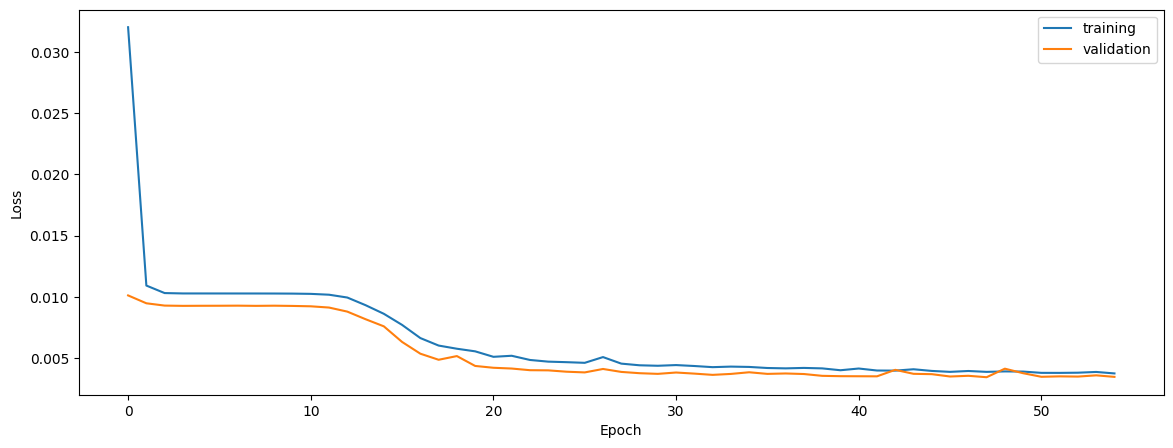

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7955785214211712
0.7937318345219666
0.7655356269904638


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7955785214211712
0.7937318345219666
0.7655356269904638


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8079587397536069
0.7995452185000484
0.7820252202092726


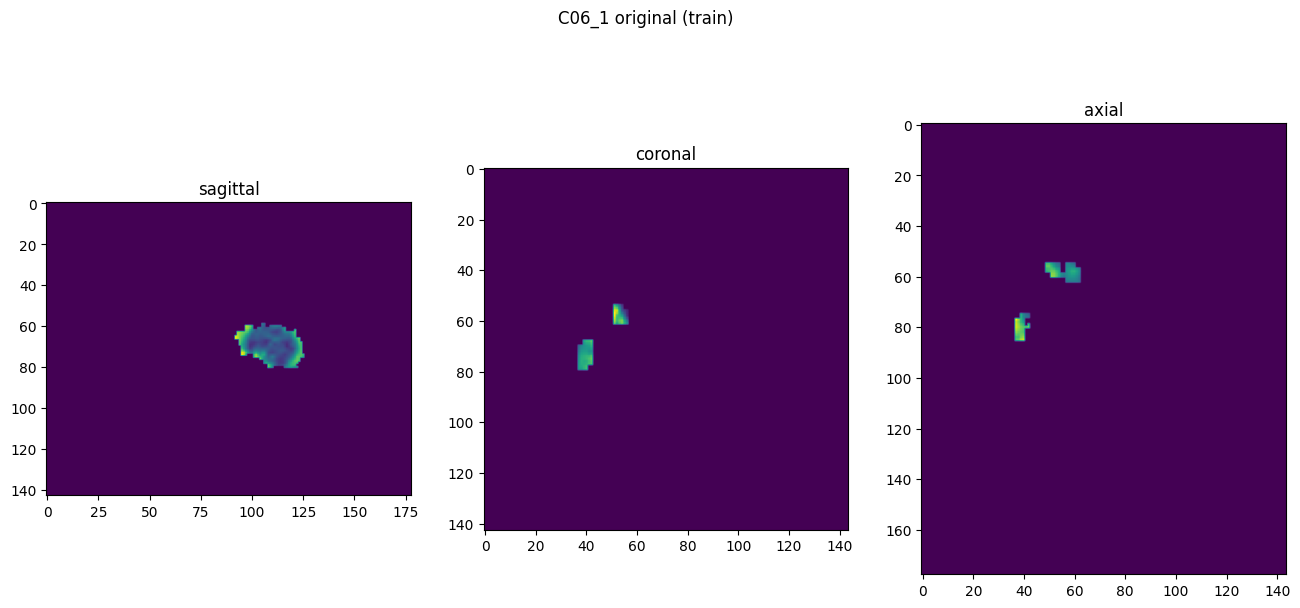

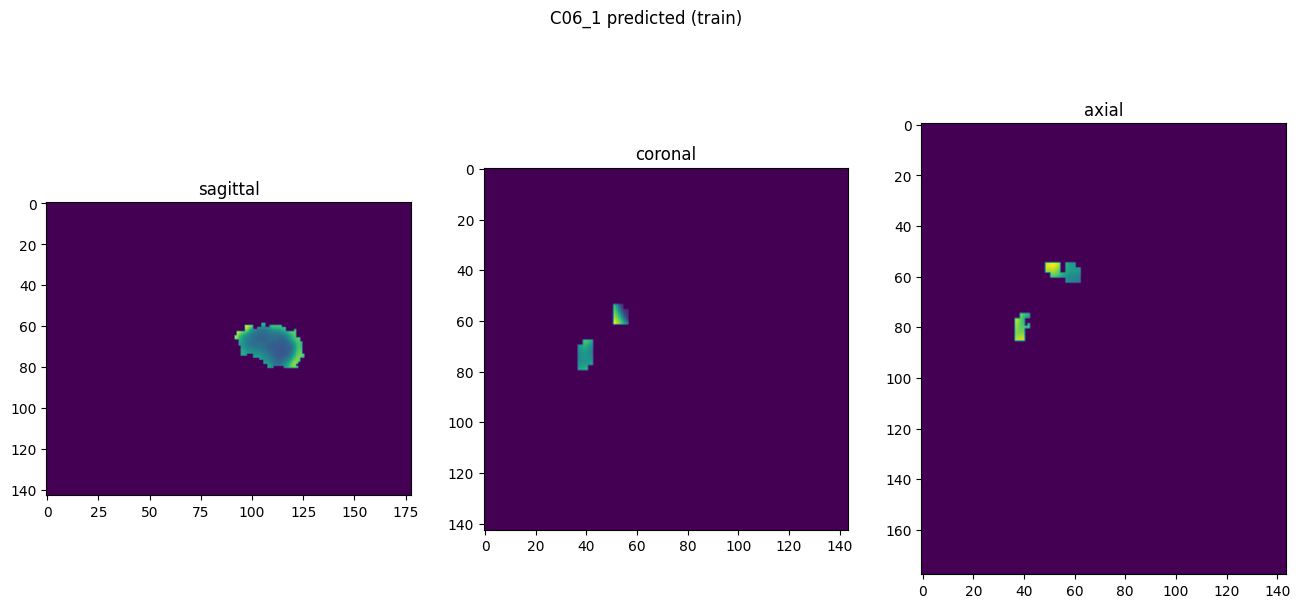

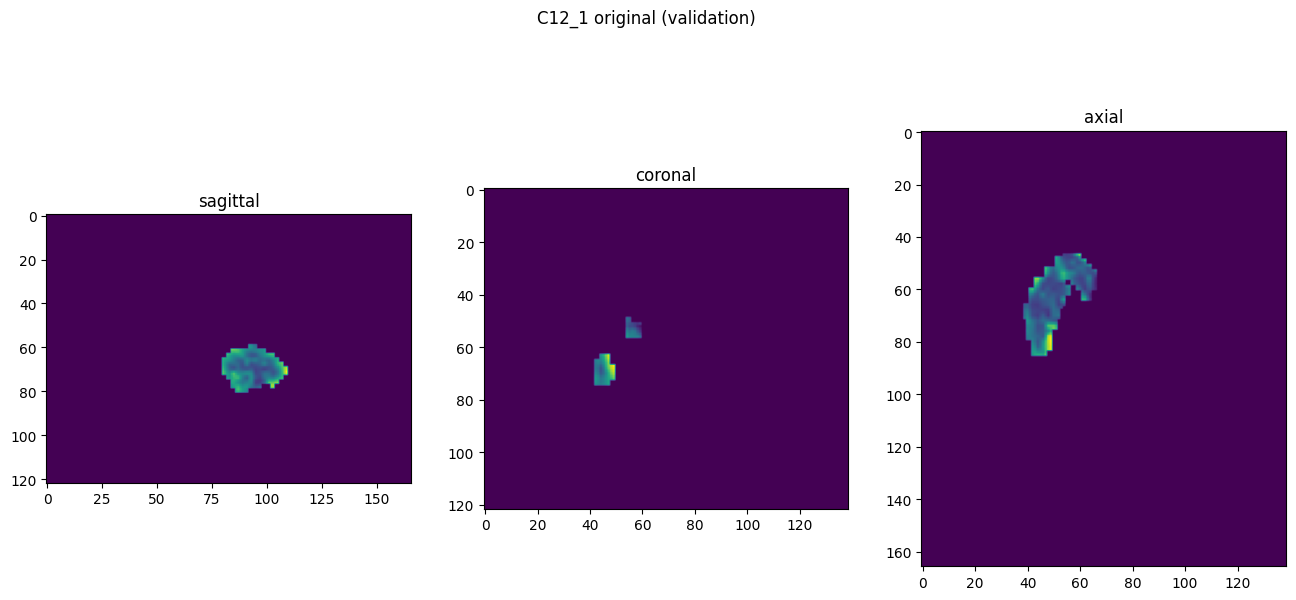

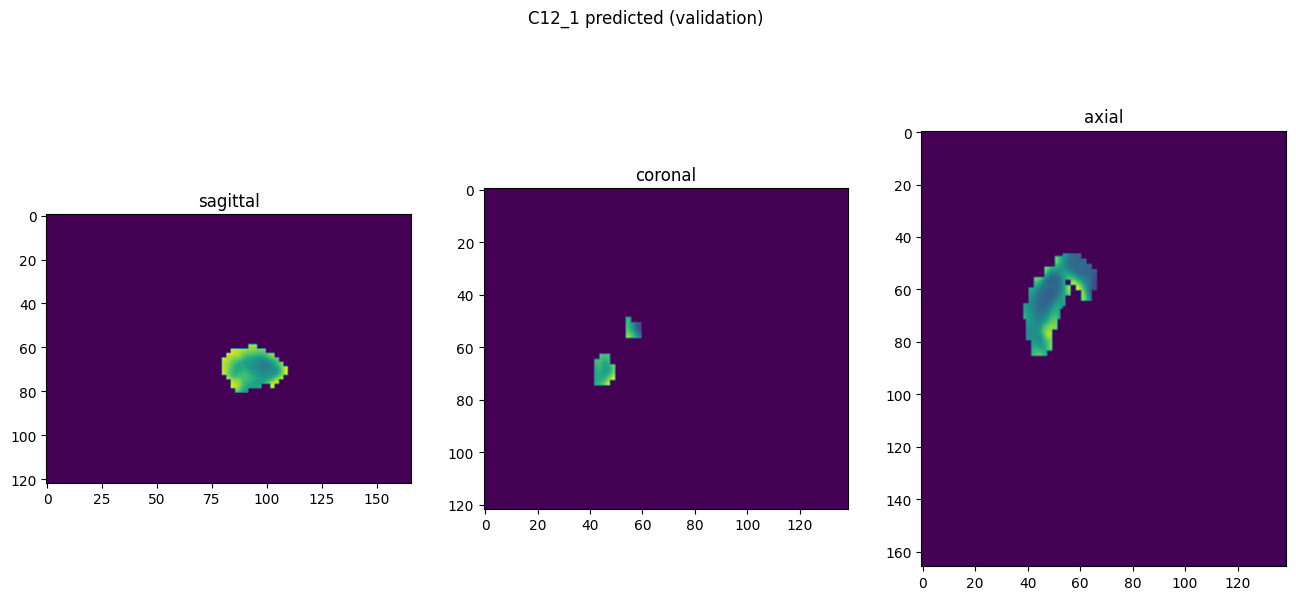

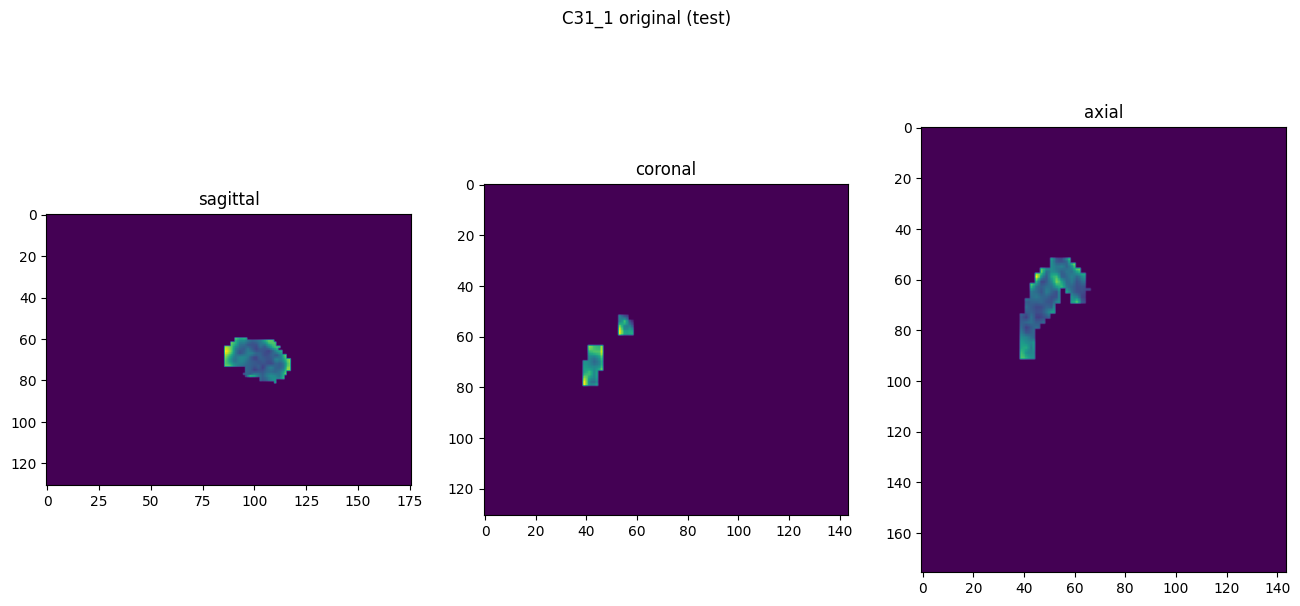

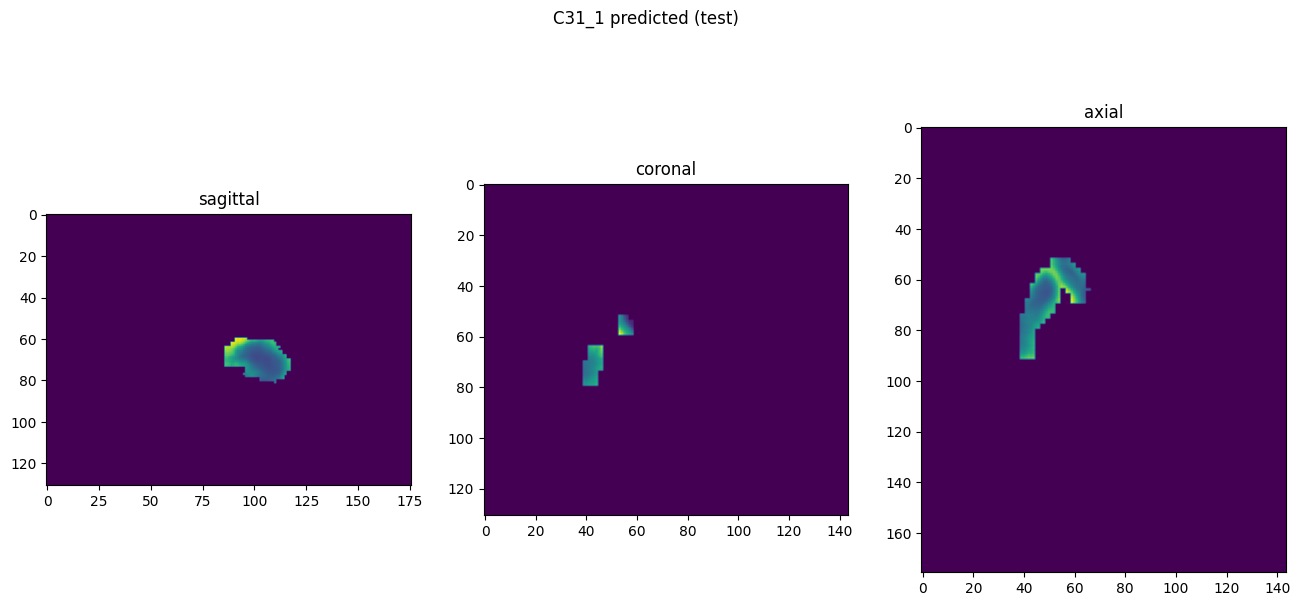

In [10]:
showResults(model, gen, threshold=None, background=False)